In [2]:
import os
import time
import json
import scipy as sp
import numpy as np
import pandas as pd
import tushare as ts
import seaborn as sns
import matplotlib.pyplot as plt

from turtle import color
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
%matplotlib inline

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.ar_model import AutoReg


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, f_regression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVR,SVR
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

from scipy.spatial.distance import pdist, squareform

### Define function

In [2]:
def model_persistence(x):
    ''' build the persistence model
        param: x
        return: x
    '''
    return x

In [148]:
# use persistence model as baseline model and check the MSE of the model 
def persistence_model_pipeline(dataset, test_size):
	''' 
		param: 
				dataset: one row/column dataframe with float/int type
				test_size: the number of test dataset size
	'''
	values = pd.DataFrame(dataset.values)
	df = pd.concat([values.shift(1), values], axis=1)
	df = df.fillna(0)
	df.columns = ['t-1', 't+1']
	X = df.values
	train, test = X[1:len(X)-test_size], X[len(X)-test_size:]
	train_X, train_y = train[:,0], train[:,1]
	test_X, test_y = test[:,0], test[:,1]

	# walk-forward validation
	predictions = list()
	for x in test_X:
		yhat = model_persistence(x)
		predictions.append(yhat)
	test_score = np.sqrt(mean_squared_error(test_y, predictions))
	print('Test RMSE: %.3f' % test_score)

	# plot predictions vs expected
	num = [i for i in range(1, test_size+1)]
	plt.figure(figsize=(7,4), dpi=100)
	plt.plot(num, test_y, color='darkred', label='Actual')
	plt.plot(num, predictions, color='coral', label='Predict')
	# plt.xticks()
	# plt.grid(True)
	plt.legend()
	plt.show()

In [154]:
# create and evaluate an updated autoregressive model
# split dataset
def autoregression_model_pipeline(dataset, test_size, predict_size, lag_value):
	''' 
		param: 
				dataset: one row/column dataframe with float/int type
				test_size: the number of test dataset size
				predict_size: the number of predict dataset size
				lag_value: selected lag value
		return: a list of prediction values
	'''
	X = dataset.values
	train, test = X[1:len(X)-test_size], X[len(X)-predict_size:]

	# train autoregression
	window = lag_value
	model = AutoReg(train, lags=lag_value)
	model_fit = model.fit()
	coef = model_fit.params

	# walk forward over time steps in test
	history = train[len(train)-window:]
	history = [history[i] for i in range(len(history))]
	predictions = list()

	for t in range(len(test)):
		length = len(history)
		lag = [history[i] for i in range(length-window,length)]
		yhat = coef[0]
		for d in range(window):
			yhat += coef[d+1] * lag[window-d-1]
		obs = test[t]
		predictions.append(yhat)
		history.append(obs)
		if test_size != 0:
			print('predicted=%f, expected=%f' % (yhat, obs))
	
	if test_size != 0:
		rmse = np.sqrt(mean_squared_error(test, predictions))
		print('Test RMSE: %.3f' % rmse)

		# plot
		num = [i for i in range(1, test_size+1)]
		col = ['Sep_2016', 'Dec_2016',
				'Mar_2017', 'Jun_2017',
				'Sep_2017', 'Dec_2017',
				'Mar_2018', 'Jun_2018',
				'Sep_2018', 'Dec_2018',
				'Mar_2019', 'Jun_2019',
				'Sep_2019', 'Dec_2019',
				'Mar_2020', 'Jun_2020',
				'Sep_2020', 'Dec_2020',
				'Mar_2021', 'Jun_2021']
		
		fig, ax = plt.subplots(figsize = (10,6))
		plt.plot(num, test, color='darkred', label='Actual')
		plt.plot(num, predictions, color='coral', label='Predict')
		# plt.ylabel('Total rent median(dollar)')
		plt.xlabel('Timeline')
		plt.xticks(rotation=90)
		plt.legend()
		plt.tight_layout()
		# plt.savefig('../plots/test.png')
		plt.show()
	
	return predictions

In [40]:
def linear_model_function(x_train, y_train, x_predict):
    train_df = pd.DataFrame()
    predict_df = pd.DataFrame()
    train_df['X'] = x_train
    train_df['Y'] = y_train
    predict_df['X'] = x_predict
    linear_model = sm.formula.ols('Y ~ X', data = train_df).fit()
    print(linear_model.summary())
    y_predict = linear_model.predict(exog=predict_df['X'], transform=True)
    predict_df['Y'] = y_predict
    print(linear_model.params)
    
    merge_list = [train_df, predict_df]
    final_df = pd.concat(merge_list)
    return final_df

In [ ]:
def entropy(probs):
    
    return -probs.dot(np.log2(probs))


def mutual_info(df):
    
    Hx = entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby(list(df.columns.values)).size()
    probs = counts/ counts.values.sum()
    H_xy = entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 

### Extract features for rental median

In [2]:
# read rental data
path = os.getcwd().replace("notebooks","") + "data/curated/"
df = pd.read_csv(path+'rental_median.csv', low_memory = True)
df = df.drop_duplicates(keep='first')
df = df[['suburb','Rental_total_Mar_2000_1b_flat', 'Rental_total_Jun_2000_1b_flat', 'Rental_total_Sep_2000_1b_flat', 'Rental_total_Dec_2000_1b_flat', 'Rental_total_Mar_2001_1b_flat', 'Rental_total_Jun_2001_1b_flat', 'Rental_total_Sep_2001_1b_flat', 'Rental_total_Dec_2001_1b_flat', 'Rental_total_Mar_2002_1b_flat', 'Rental_total_Jun_2002_1b_flat', 'Rental_total_Sep_2002_1b_flat', 'Rental_total_Dec_2002_1b_flat', 'Rental_total_Mar_2003_1b_flat', 'Rental_total_Jun_2003_1b_flat', 'Rental_total_Sep_2003_1b_flat', 'Rental_total_Dec_2003_1b_flat', 'Rental_total_Mar_2004_1b_flat', 'Rental_total_Jun_2004_1b_flat', 'Rental_total_Sep_2004_1b_flat', 'Rental_total_Dec_2004_1b_flat', 'Rental_total_Mar_2005_1b_flat', 'Rental_total_Jun_2005_1b_flat', 'Rental_total_Sep_2005_1b_flat', 'Rental_total_Dec_2005_1b_flat', 'Rental_total_Mar_2006_1b_flat', 'Rental_total_Jun_2006_1b_flat', 'Rental_total_Sep_2006_1b_flat', 'Rental_total_Dec_2006_1b_flat', 'Rental_total_Mar_2007_1b_flat', 'Rental_total_Jun_2007_1b_flat', 'Rental_total_Sep_2007_1b_flat', 'Rental_total_Dec_2007_1b_flat', 'Rental_total_Mar_2008_1b_flat', 'Rental_total_Jun_2008_1b_flat', 'Rental_total_Sep_2008_1b_flat', 'Rental_total_Dec_2008_1b_flat', 'Rental_total_Mar_2009_1b_flat', 'Rental_total_Jun_2009_1b_flat', 'Rental_total_Sep_2009_1b_flat', 'Rental_total_Dec_2009_1b_flat', 'Rental_total_Mar_2010_1b_flat', 'Rental_total_Jun_2010_1b_flat', 'Rental_total_Sep_2010_1b_flat', 'Rental_total_Dec_2010_1b_flat', 'Rental_total_Mar_2011_1b_flat', 'Rental_total_Jun_2011_1b_flat', 'Rental_total_Sep_2011_1b_flat', 'Rental_total_Dec_2011_1b_flat', 'Rental_total_Mar_2012_1b_flat', 'Rental_total_Jun_2012_1b_flat', 'Rental_total_Sep_2012_1b_flat', 'Rental_total_Dec_2012_1b_flat', 'Rental_total_Mar_2013_1b_flat', 'Rental_total_Jun_2013_1b_flat', 'Rental_total_Sep_2013_1b_flat', 'Rental_total_Dec_2013_1b_flat', 'Rental_total_Mar_2014_1b_flat', 'Rental_total_Jun_2014_1b_flat', 'Rental_total_Sep_2014_1b_flat', 'Rental_total_Dec_2014_1b_flat', 'Rental_total_Mar_2015_1b_flat', 'Rental_total_Jun_2015_1b_flat', 'Rental_total_Sep_2015_1b_flat', 'Rental_total_Dec_2015_1b_flat', 'Rental_total_Mar_2016_1b_flat', 'Rental_total_Jun_2016_1b_flat', 'Rental_total_Sep_2016_1b_flat', 'Rental_total_Dec_2016_1b_flat', 'Rental_total_Mar_2017_1b_flat', 'Rental_total_Jun_2017_1b_flat', 'Rental_total_Sep_2017_1b_flat', 'Rental_total_Dec_2017_1b_flat', 'Rental_total_Mar_2018_1b_flat', 'Rental_total_Jun_2018_1b_flat', 'Rental_total_Sep_2018_1b_flat', 'Rental_total_Dec_2018_1b_flat', 'Rental_total_Mar_2019_1b_flat', 'Rental_total_Jun_2019_1b_flat', 'Rental_total_Sep_2019_1b_flat', 'Rental_total_Dec_2019_1b_flat', 'Rental_total_Mar_2020_1b_flat', 'Rental_total_Jun_2020_1b_flat', 'Rental_total_Sep_2020_1b_flat', 'Rental_total_Dec_2020_1b_flat', 'Rental_total_Mar_2021_1b_flat', 'Rental_total_Jun_2021_1b_flat', 'Rental_total_Mar_2000_2b_flat', 'Rental_total_Jun_2000_2b_flat', 'Rental_total_Sep_2000_2b_flat', 'Rental_total_Dec_2000_2b_flat', 'Rental_total_Mar_2001_2b_flat', 'Rental_total_Jun_2001_2b_flat', 'Rental_total_Sep_2001_2b_flat', 'Rental_total_Dec_2001_2b_flat', 'Rental_total_Mar_2002_2b_flat', 'Rental_total_Jun_2002_2b_flat', 'Rental_total_Sep_2002_2b_flat', 'Rental_total_Dec_2002_2b_flat', 'Rental_total_Mar_2003_2b_flat', 'Rental_total_Jun_2003_2b_flat', 'Rental_total_Sep_2003_2b_flat', 'Rental_total_Dec_2003_2b_flat', 'Rental_total_Mar_2004_2b_flat', 'Rental_total_Jun_2004_2b_flat', 'Rental_total_Sep_2004_2b_flat', 'Rental_total_Dec_2004_2b_flat', 'Rental_total_Mar_2005_2b_flat', 'Rental_total_Jun_2005_2b_flat', 'Rental_total_Sep_2005_2b_flat', 'Rental_total_Dec_2005_2b_flat', 'Rental_total_Mar_2006_2b_flat', 'Rental_total_Jun_2006_2b_flat', 'Rental_total_Sep_2006_2b_flat', 'Rental_total_Dec_2006_2b_flat', 'Rental_total_Mar_2007_2b_flat', 'Rental_total_Jun_2007_2b_flat', 'Rental_total_Sep_2007_2b_flat', 'Rental_total_Dec_2007_2b_flat', 'Rental_total_Mar_2008_2b_flat', 'Rental_total_Jun_2008_2b_flat', 'Rental_total_Sep_2008_2b_flat', 'Rental_total_Dec_2008_2b_flat', 'Rental_total_Mar_2009_2b_flat', 'Rental_total_Jun_2009_2b_flat', 'Rental_total_Sep_2009_2b_flat', 'Rental_total_Dec_2009_2b_flat', 'Rental_total_Mar_2010_2b_flat', 'Rental_total_Jun_2010_2b_flat', 'Rental_total_Sep_2010_2b_flat', 'Rental_total_Dec_2010_2b_flat', 'Rental_total_Mar_2011_2b_flat', 'Rental_total_Jun_2011_2b_flat', 'Rental_total_Sep_2011_2b_flat', 'Rental_total_Dec_2011_2b_flat', 'Rental_total_Mar_2012_2b_flat', 'Rental_total_Jun_2012_2b_flat', 'Rental_total_Sep_2012_2b_flat', 'Rental_total_Dec_2012_2b_flat', 'Rental_total_Mar_2013_2b_flat', 'Rental_total_Jun_2013_2b_flat', 'Rental_total_Sep_2013_2b_flat', 'Rental_total_Dec_2013_2b_flat', 'Rental_total_Mar_2014_2b_flat', 'Rental_total_Jun_2014_2b_flat', 'Rental_total_Sep_2014_2b_flat', 'Rental_total_Dec_2014_2b_flat', 'Rental_total_Mar_2015_2b_flat', 'Rental_total_Jun_2015_2b_flat', 'Rental_total_Sep_2015_2b_flat', 'Rental_total_Dec_2015_2b_flat', 'Rental_total_Mar_2016_2b_flat', 'Rental_total_Jun_2016_2b_flat', 'Rental_total_Sep_2016_2b_flat', 'Rental_total_Dec_2016_2b_flat', 'Rental_total_Mar_2017_2b_flat', 'Rental_total_Jun_2017_2b_flat', 'Rental_total_Sep_2017_2b_flat', 'Rental_total_Dec_2017_2b_flat', 'Rental_total_Mar_2018_2b_flat', 'Rental_total_Jun_2018_2b_flat', 'Rental_total_Sep_2018_2b_flat', 'Rental_total_Dec_2018_2b_flat', 'Rental_total_Mar_2019_2b_flat', 'Rental_total_Jun_2019_2b_flat', 'Rental_total_Sep_2019_2b_flat', 'Rental_total_Dec_2019_2b_flat', 'Rental_total_Mar_2020_2b_flat', 'Rental_total_Jun_2020_2b_flat', 'Rental_total_Sep_2020_2b_flat', 'Rental_total_Dec_2020_2b_flat', 'Rental_total_Mar_2021_2b_flat', 'Rental_total_Jun_2021_2b_flat', 'Rental_total_Mar_2000_3b_flat', 'Rental_total_Jun_2000_3b_flat', 'Rental_total_Sep_2000_3b_flat', 'Rental_total_Dec_2000_3b_flat', 'Rental_total_Mar_2001_3b_flat', 'Rental_total_Jun_2001_3b_flat', 'Rental_total_Sep_2001_3b_flat', 'Rental_total_Dec_2001_3b_flat', 'Rental_total_Mar_2002_3b_flat', 'Rental_total_Jun_2002_3b_flat', 'Rental_total_Sep_2002_3b_flat', 'Rental_total_Dec_2002_3b_flat', 'Rental_total_Mar_2003_3b_flat', 'Rental_total_Jun_2003_3b_flat', 'Rental_total_Sep_2003_3b_flat', 'Rental_total_Dec_2003_3b_flat', 'Rental_total_Mar_2004_3b_flat', 'Rental_total_Jun_2004_3b_flat', 'Rental_total_Sep_2004_3b_flat', 'Rental_total_Dec_2004_3b_flat', 'Rental_total_Mar_2005_3b_flat', 'Rental_total_Jun_2005_3b_flat', 'Rental_total_Sep_2005_3b_flat', 'Rental_total_Dec_2005_3b_flat', 'Rental_total_Mar_2006_3b_flat', 'Rental_total_Jun_2006_3b_flat', 'Rental_total_Sep_2006_3b_flat', 'Rental_total_Dec_2006_3b_flat', 'Rental_total_Mar_2007_3b_flat', 'Rental_total_Jun_2007_3b_flat', 'Rental_total_Sep_2007_3b_flat', 'Rental_total_Dec_2007_3b_flat', 'Rental_total_Mar_2008_3b_flat', 'Rental_total_Jun_2008_3b_flat', 'Rental_total_Sep_2008_3b_flat', 'Rental_total_Dec_2008_3b_flat', 'Rental_total_Mar_2009_3b_flat', 'Rental_total_Jun_2009_3b_flat', 'Rental_total_Sep_2009_3b_flat', 'Rental_total_Dec_2009_3b_flat', 'Rental_total_Mar_2010_3b_flat', 'Rental_total_Jun_2010_3b_flat', 'Rental_total_Sep_2010_3b_flat', 'Rental_total_Dec_2010_3b_flat', 'Rental_total_Mar_2011_3b_flat', 'Rental_total_Jun_2011_3b_flat', 'Rental_total_Sep_2011_3b_flat', 'Rental_total_Dec_2011_3b_flat', 'Rental_total_Mar_2012_3b_flat', 'Rental_total_Jun_2012_3b_flat', 'Rental_total_Sep_2012_3b_flat', 'Rental_total_Dec_2012_3b_flat', 'Rental_total_Mar_2013_3b_flat', 'Rental_total_Jun_2013_3b_flat', 'Rental_total_Sep_2013_3b_flat', 'Rental_total_Dec_2013_3b_flat', 'Rental_total_Mar_2014_3b_flat', 'Rental_total_Jun_2014_3b_flat', 'Rental_total_Sep_2014_3b_flat', 'Rental_total_Dec_2014_3b_flat', 'Rental_total_Mar_2015_3b_flat', 'Rental_total_Jun_2015_3b_flat', 'Rental_total_Sep_2015_3b_flat', 'Rental_total_Dec_2015_3b_flat', 'Rental_total_Mar_2016_3b_flat', 'Rental_total_Jun_2016_3b_flat', 'Rental_total_Sep_2016_3b_flat', 'Rental_total_Dec_2016_3b_flat', 'Rental_total_Mar_2017_3b_flat', 'Rental_total_Jun_2017_3b_flat', 'Rental_total_Sep_2017_3b_flat', 'Rental_total_Dec_2017_3b_flat', 'Rental_total_Mar_2018_3b_flat', 'Rental_total_Jun_2018_3b_flat', 'Rental_total_Sep_2018_3b_flat', 'Rental_total_Dec_2018_3b_flat', 'Rental_total_Mar_2019_3b_flat', 'Rental_total_Jun_2019_3b_flat', 'Rental_total_Sep_2019_3b_flat', 'Rental_total_Dec_2019_3b_flat', 'Rental_total_Mar_2020_3b_flat', 'Rental_total_Jun_2020_3b_flat', 'Rental_total_Sep_2020_3b_flat', 'Rental_total_Dec_2020_3b_flat', 'Rental_total_Mar_2021_3b_flat', 'Rental_total_Jun_2021_3b_flat', 'Rental_total_Mar_2000_2b_house', 'Rental_total_Jun_2000_2b_house', 'Rental_total_Sep_2000_2b_house', 'Rental_total_Dec_2000_2b_house', 'Rental_total_Mar_2001_2b_house', 'Rental_total_Jun_2001_2b_house', 'Rental_total_Sep_2001_2b_house', 'Rental_total_Dec_2001_2b_house', 'Rental_total_Mar_2002_2b_house', 'Rental_total_Jun_2002_2b_house', 'Rental_total_Sep_2002_2b_house', 'Rental_total_Dec_2002_2b_house', 'Rental_total_Mar_2003_2b_house', 'Rental_total_Jun_2003_2b_house', 'Rental_total_Sep_2003_2b_house', 'Rental_total_Dec_2003_2b_house', 'Rental_total_Mar_2004_2b_house', 'Rental_total_Jun_2004_2b_house', 'Rental_total_Sep_2004_2b_house', 'Rental_total_Dec_2004_2b_house', 'Rental_total_Mar_2005_2b_house', 'Rental_total_Jun_2005_2b_house', 'Rental_total_Sep_2005_2b_house', 'Rental_total_Dec_2005_2b_house', 'Rental_total_Mar_2006_2b_house', 'Rental_total_Jun_2006_2b_house', 'Rental_total_Sep_2006_2b_house', 'Rental_total_Dec_2006_2b_house', 'Rental_total_Mar_2007_2b_house', 'Rental_total_Jun_2007_2b_house', 'Rental_total_Sep_2007_2b_house', 'Rental_total_Dec_2007_2b_house', 'Rental_total_Mar_2008_2b_house', 'Rental_total_Jun_2008_2b_house', 'Rental_total_Sep_2008_2b_house', 'Rental_total_Dec_2008_2b_house', 'Rental_total_Mar_2009_2b_house', 'Rental_total_Jun_2009_2b_house', 'Rental_total_Sep_2009_2b_house', 'Rental_total_Dec_2009_2b_house', 'Rental_total_Mar_2010_2b_house', 'Rental_total_Jun_2010_2b_house', 'Rental_total_Sep_2010_2b_house', 'Rental_total_Dec_2010_2b_house', 'Rental_total_Mar_2011_2b_house', 'Rental_total_Jun_2011_2b_house', 'Rental_total_Sep_2011_2b_house', 'Rental_total_Dec_2011_2b_house', 'Rental_total_Mar_2012_2b_house', 'Rental_total_Jun_2012_2b_house', 'Rental_total_Sep_2012_2b_house', 'Rental_total_Dec_2012_2b_house', 'Rental_total_Mar_2013_2b_house', 'Rental_total_Jun_2013_2b_house', 'Rental_total_Sep_2013_2b_house', 'Rental_total_Dec_2013_2b_house', 'Rental_total_Mar_2014_2b_house', 'Rental_total_Jun_2014_2b_house', 'Rental_total_Sep_2014_2b_house', 'Rental_total_Dec_2014_2b_house', 'Rental_total_Mar_2015_2b_house', 'Rental_total_Jun_2015_2b_house', 'Rental_total_Sep_2015_2b_house', 'Rental_total_Dec_2015_2b_house', 'Rental_total_Mar_2016_2b_house', 'Rental_total_Jun_2016_2b_house', 'Rental_total_Sep_2016_2b_house', 'Rental_total_Dec_2016_2b_house', 'Rental_total_Mar_2017_2b_house', 'Rental_total_Jun_2017_2b_house', 'Rental_total_Sep_2017_2b_house', 'Rental_total_Dec_2017_2b_house', 'Rental_total_Mar_2018_2b_house', 'Rental_total_Jun_2018_2b_house', 'Rental_total_Sep_2018_2b_house', 'Rental_total_Dec_2018_2b_house', 'Rental_total_Mar_2019_2b_house', 'Rental_total_Jun_2019_2b_house', 'Rental_total_Sep_2019_2b_house', 'Rental_total_Dec_2019_2b_house', 'Rental_total_Mar_2020_2b_house', 'Rental_total_Jun_2020_2b_house', 'Rental_total_Sep_2020_2b_house', 'Rental_total_Dec_2020_2b_house', 'Rental_total_Mar_2021_2b_house', 'Rental_total_Jun_2021_2b_house', 'Rental_total_Mar_2000_3b_house', 'Rental_total_Jun_2000_3b_house', 'Rental_total_Sep_2000_3b_house', 'Rental_total_Dec_2000_3b_house', 'Rental_total_Mar_2001_3b_house', 'Rental_total_Jun_2001_3b_house', 'Rental_total_Sep_2001_3b_house', 'Rental_total_Dec_2001_3b_house', 'Rental_total_Mar_2002_3b_house', 'Rental_total_Jun_2002_3b_house', 'Rental_total_Sep_2002_3b_house', 'Rental_total_Dec_2002_3b_house', 'Rental_total_Mar_2003_3b_house', 'Rental_total_Jun_2003_3b_house', 'Rental_total_Sep_2003_3b_house', 'Rental_total_Dec_2003_3b_house', 'Rental_total_Mar_2004_3b_house', 'Rental_total_Jun_2004_3b_house', 'Rental_total_Sep_2004_3b_house', 'Rental_total_Dec_2004_3b_house', 'Rental_total_Mar_2005_3b_house', 'Rental_total_Jun_2005_3b_house', 'Rental_total_Sep_2005_3b_house', 'Rental_total_Dec_2005_3b_house', 'Rental_total_Mar_2006_3b_house', 'Rental_total_Jun_2006_3b_house', 'Rental_total_Sep_2006_3b_house', 'Rental_total_Dec_2006_3b_house', 'Rental_total_Mar_2007_3b_house', 'Rental_total_Jun_2007_3b_house', 'Rental_total_Sep_2007_3b_house', 'Rental_total_Dec_2007_3b_house', 'Rental_total_Mar_2008_3b_house', 'Rental_total_Jun_2008_3b_house', 'Rental_total_Sep_2008_3b_house', 'Rental_total_Dec_2008_3b_house', 'Rental_total_Mar_2009_3b_house', 'Rental_total_Jun_2009_3b_house', 'Rental_total_Sep_2009_3b_house', 'Rental_total_Dec_2009_3b_house', 'Rental_total_Mar_2010_3b_house', 'Rental_total_Jun_2010_3b_house', 'Rental_total_Sep_2010_3b_house', 'Rental_total_Dec_2010_3b_house', 'Rental_total_Mar_2011_3b_house', 'Rental_total_Jun_2011_3b_house', 'Rental_total_Sep_2011_3b_house', 'Rental_total_Dec_2011_3b_house', 'Rental_total_Mar_2012_3b_house', 'Rental_total_Jun_2012_3b_house', 'Rental_total_Sep_2012_3b_house', 'Rental_total_Dec_2012_3b_house', 'Rental_total_Mar_2013_3b_house', 'Rental_total_Jun_2013_3b_house', 'Rental_total_Sep_2013_3b_house', 'Rental_total_Dec_2013_3b_house', 'Rental_total_Mar_2014_3b_house', 'Rental_total_Jun_2014_3b_house', 'Rental_total_Sep_2014_3b_house', 'Rental_total_Dec_2014_3b_house', 'Rental_total_Mar_2015_3b_house', 'Rental_total_Jun_2015_3b_house', 'Rental_total_Sep_2015_3b_house', 'Rental_total_Dec_2015_3b_house', 'Rental_total_Mar_2016_3b_house', 'Rental_total_Jun_2016_3b_house', 'Rental_total_Sep_2016_3b_house', 'Rental_total_Dec_2016_3b_house', 'Rental_total_Mar_2017_3b_house', 'Rental_total_Jun_2017_3b_house', 'Rental_total_Sep_2017_3b_house', 'Rental_total_Dec_2017_3b_house', 'Rental_total_Mar_2018_3b_house', 'Rental_total_Jun_2018_3b_house', 'Rental_total_Sep_2018_3b_house', 'Rental_total_Dec_2018_3b_house', 'Rental_total_Mar_2019_3b_house', 'Rental_total_Jun_2019_3b_house', 'Rental_total_Sep_2019_3b_house', 'Rental_total_Dec_2019_3b_house', 'Rental_total_Mar_2020_3b_house', 'Rental_total_Jun_2020_3b_house', 'Rental_total_Sep_2020_3b_house', 'Rental_total_Dec_2020_3b_house', 'Rental_total_Mar_2021_3b_house', 'Rental_total_Jun_2021_3b_house', 'Rental_total_Mar_2000_4b_house', 'Rental_total_Jun_2000_4b_house', 'Rental_total_Sep_2000_4b_house', 'Rental_total_Dec_2000_4b_house', 'Rental_total_Mar_2001_4b_house', 'Rental_total_Jun_2001_4b_house', 'Rental_total_Sep_2001_4b_house', 'Rental_total_Dec_2001_4b_house', 'Rental_total_Mar_2002_4b_house', 'Rental_total_Jun_2002_4b_house', 'Rental_total_Sep_2002_4b_house', 'Rental_total_Dec_2002_4b_house', 'Rental_total_Mar_2003_4b_house', 'Rental_total_Jun_2003_4b_house', 'Rental_total_Sep_2003_4b_house', 'Rental_total_Dec_2003_4b_house', 'Rental_total_Mar_2004_4b_house', 'Rental_total_Jun_2004_4b_house', 'Rental_total_Sep_2004_4b_house', 'Rental_total_Dec_2004_4b_house', 'Rental_total_Mar_2005_4b_house', 'Rental_total_Jun_2005_4b_house', 'Rental_total_Sep_2005_4b_house', 'Rental_total_Dec_2005_4b_house', 'Rental_total_Mar_2006_4b_house', 'Rental_total_Jun_2006_4b_house', 'Rental_total_Sep_2006_4b_house', 'Rental_total_Dec_2006_4b_house', 'Rental_total_Mar_2007_4b_house', 'Rental_total_Jun_2007_4b_house', 'Rental_total_Sep_2007_4b_house', 'Rental_total_Dec_2007_4b_house', 'Rental_total_Mar_2008_4b_house', 'Rental_total_Jun_2008_4b_house', 'Rental_total_Sep_2008_4b_house', 'Rental_total_Dec_2008_4b_house', 'Rental_total_Mar_2009_4b_house', 'Rental_total_Jun_2009_4b_house', 'Rental_total_Sep_2009_4b_house', 'Rental_total_Dec_2009_4b_house', 'Rental_total_Mar_2010_4b_house', 'Rental_total_Jun_2010_4b_house', 'Rental_total_Sep_2010_4b_house', 'Rental_total_Dec_2010_4b_house', 'Rental_total_Mar_2011_4b_house', 'Rental_total_Jun_2011_4b_house', 'Rental_total_Sep_2011_4b_house', 'Rental_total_Dec_2011_4b_house', 'Rental_total_Mar_2012_4b_house', 'Rental_total_Jun_2012_4b_house', 'Rental_total_Sep_2012_4b_house', 'Rental_total_Dec_2012_4b_house', 'Rental_total_Mar_2013_4b_house', 'Rental_total_Jun_2013_4b_house', 'Rental_total_Sep_2013_4b_house', 'Rental_total_Dec_2013_4b_house', 'Rental_total_Mar_2014_4b_house', 'Rental_total_Jun_2014_4b_house', 'Rental_total_Sep_2014_4b_house', 'Rental_total_Dec_2014_4b_house', 'Rental_total_Mar_2015_4b_house', 'Rental_total_Jun_2015_4b_house', 'Rental_total_Sep_2015_4b_house', 'Rental_total_Dec_2015_4b_house', 'Rental_total_Mar_2016_4b_house', 'Rental_total_Jun_2016_4b_house', 'Rental_total_Sep_2016_4b_house', 'Rental_total_Dec_2016_4b_house', 'Rental_total_Mar_2017_4b_house', 'Rental_total_Jun_2017_4b_house', 'Rental_total_Sep_2017_4b_house', 'Rental_total_Dec_2017_4b_house', 'Rental_total_Mar_2018_4b_house', 'Rental_total_Jun_2018_4b_house', 'Rental_total_Sep_2018_4b_house', 'Rental_total_Dec_2018_4b_house', 'Rental_total_Mar_2019_4b_house', 'Rental_total_Jun_2019_4b_house', 'Rental_total_Sep_2019_4b_house', 'Rental_total_Dec_2019_4b_house', 'Rental_total_Mar_2020_4b_house', 'Rental_total_Jun_2020_4b_house', 'Rental_total_Sep_2020_4b_house', 'Rental_total_Dec_2020_4b_house', 'Rental_total_Mar_2021_4b_house', 'Rental_total_Jun_2021_4b_house', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
df = df[['suburb', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
# df

In [3]:
for suburb in [x for x in df.columns][1:]:
    df[suburb] = df[suburb].replace("-",np.nan)
    df[suburb] = df[suburb].astype(float)
df = df.fillna(0)
# df

#### Predict rent for future 3 years

In [ ]:
train_x = df.loc[:, 'Rental_total_Mar_2000': 'Rental_total_Mar_2021']

In [ ]:


plt.plot(train_x.columns.to_list(), train_x.iloc[3].to_list())

In [ ]:
from sklearn.linear_model import Ridge
train_x = df.loc[:, 'Rental_total_Mar_2000': 'Rental_total_Mar_2021']
# train_x = df[['Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021']]
train_y = df['Rental_total_Jun_2021']

# split train test dataset
# x_train_rent, x_test_rent, y_train_rent, y_test_rent = train_test_split(train_x,train_y, train_size=0.7,test_size=0.3,random_state=42)

# set up ridge regression
ridge = Ridge(alpha=50)
ridge.fit(train_x, train_y)
pred=ridge.predict(train_x)
print("The score is: ", ridge.score(train_x, train_y))

# calculate rmse for model
mse = mean_squared_error(train_y,pred)
rmse = mse ** (1/2)
print("The predict rmse is: ", rmse)

In [ ]:

# set up Lasso regression
lasso = Lasso(max_iter=300000, alpha = 0.01)
lasso.fit(train_x, train_y)
pred = lasso.predict(train_x)
print("The score is: ", lasso.score(train_x, train_y))


# calculate rmse for model
mse = mean_squared_error(train_y,pred)
rmse = mse ** (1/2)
print("The predict rmse is: ", rmse)

In [ ]:
# since one year rental contains four sections
predict_X_train = train_x
predict_Y_train = train_y

for year in ['2021', '2022', '2023', '2024', '2025']:
    for month in ['Mar', 'Jun', 'Sep', 'Dec']:
        if year == "2021" and month == "Mar":
            continue
        lasso.fit(predict_X_train, predict_Y_train)
        pred =lasso.predict(predict_X_train)
        
        predict_X_train[f'Rental_total_{month}_{year}'] = predict_Y_train
        predict_Y_train = pred



In [ ]:
predict_X_train

In [ ]:
ridge = Ridge()
params = {
    "alpha": [0.005, 0.01, 1, 5, 10, 20, 50],
    "max_iter": [300000,30]
}
model1 = GridSearchCV(ridge, param_grid=params, cv=5, n_jobs=-1)
model1.fit(train_x, train_y)
model1.best_params_

#### Predict population for future 3 years

In [ ]:
df = df.transpose()
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df["date"] = df.index
df

### Feature Engineering

In [ ]:
# 9.29 start now:

In [ ]:
property_df = pd.read_csv('../data/curated/cleaned_property_data_new.csv', low_memory = False)
property_df['cloest_train_station'] = property_df['cloest_train_station'].apply(eval)
property_df['coordinates'] = property_df['coordinates'].apply(eval)

In [ ]:
# drop station for now
property_df_temp = property_df.drop(columns = ['cloest_train_station', 'cloest_tram_stop', 'cloest_bus_stop'])


In [ ]:
property_df_temp.columns

In [ ]:
Rental_list = []
Others = []
for col in property_df_temp.columns:
    if 'Rental' in col:
        Rental_list.append(col)
    else:
        Others.append(col)

In [ ]:
#Other_df = property_df_temp[Others].copy()
Other_df = property_df_temp.copy()
# replace type name
Other_df['type'] = Other_df['type'].replace('Apartment / Unit / Flat', 'Apartment / Unit / Flat / Penhouse')
Other_df['type'] = Other_df['type'].replace('Penthouse', 'Apartment / Unit / Flat / Penhouse')

# Change to numerical
Other_df = Other_df.replace('-', -1)

Other_df['furnitured'] = Other_df['furnitured'].replace('Yes', 1)
Other_df['furnitured'] = Other_df['furnitured'].replace('No', 0)

Other_df['pool'] = Other_df['pool'].replace('Yes', 1)
Other_df['pool'] = Other_df['pool'].replace('No', 0)

Other_df['gym'] = Other_df['gym'].replace('Yes', 1)
Other_df['gym'] = Other_df['gym'].replace('No', 0)

# fill
Other_df = Other_df.fillna(-1)

# drop
Other_df = Other_df.drop(columns=['postcode'])

In [ ]:
pie_data = Other_df['type'].value_counts()
labels = pie_data.index
sizes = pie_data.values
#get label and size
fig, ax = plt.subplots(figsize = (10,10))
#draw the pie char and modify the pie chart
patches, texts, pcts = ax.pie(pie_data ,explode=None,autopct='%1.1f%%',
                               pctdistance = 0.7, labels=labels,wedgeprops={'linewidth': 3.0, 'edgecolor': 'black'},
                               textprops={'size': 'x-large'})

plt.setp(pcts, color='white', fontweight='bold')  #label color
# face color.
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.legend(labels,prop={'size': 12},bbox_to_anchor=(1.0, 1.0))
plt.title("Pie Chart for Property Type", x=0.5, y=1.1,fontsize=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

fig.figure.savefig('../plots/type_pie.png')

In [ ]:
Other_df['type'] = Other_df['type'].replace('Apartment / Unit / Flat / Penhouse', 1)
Other_df['type'] = Other_df['type'].replace('Studio', 2)
Other_df['type'] = Other_df['type'].replace('Townhouse', 3)
Other_df['type'] = Other_df['type'].replace('House', 4)
Other_df['type'] = Other_df['type'].replace('Penthouse', 5)

In [ ]:
#Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(Other_df["rent_weekly"], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent',fontsize=15)
axs[0,0].set_ylabel("AUD",fontsize=15)
plt.show()
fig.figure.savefig('../plots/boxplot_before.png')

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title('weekly rent distribution', fontsize=18)
sns.histplot(Other_df['rent_weekly'])

In [ ]:
Other_df["rent_weekly"].describe()

In [ ]:
Q1 = Other_df["rent_weekly"].quantile(0.25)
Q3 = Other_df["rent_weekly"].quantile(0.75)
IQR = Q3 - Q1
Other_df = Other_df[~((Other_df["rent_weekly"] < (Q1 - 1.5 * IQR)) | (Other_df["rent_weekly"] > (Q3 + 1.5 * IQR)))]
Other_df = Other_df.reset_index(drop=True)

In [ ]:
#Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(Other_df["rent_weekly"], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent after delete outlier',fontsize=15)
axs[0,0].set_ylabel("AUD",fontsize=15)
plt.show()
fig.figure.savefig('../plots/boxplot_after.png')

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title('weekly rent distribution after delete outlier', fontsize=18)
sns.distplot(Other_df['rent_weekly'])

In [ ]:
def convert_suburb(df):
    suburb_lis = list(df['suburb'].unique())
    for i in range(1,len(suburb_lis)+1):
        df['suburb'] = df['suburb'].replace(suburb_lis[i-1],i)
    return df

In [ ]:
Other_df = convert_suburb(Other_df)

In [ ]:
plt.figure(figsize=(25,25),dpi=100)
plt.title('Pearson Correlation bewteen features', fontsize=12)
#sns.heatmap(Other_df.corr(), annot=Other_df.corr(), annot_kws={"fontsize":7})
sns.heatmap(Other_df.corr())
plt.tight_layout()
plt.show()

In [ ]:
# print(Other_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).to_dict())
#Other_df.corr().abs().sort_values(by=['rent_weekly'],ascending=True).iloc[0]

In [ ]:
other_lis = []
column_lis = []
for col in Other_df.columns:
    if (('Rental_total' in col) and ('house' not in col) and ('flat' not in col)) or 'Rental' not in col:
        column_lis.append(col)
    else:
        other_lis.append(col)

In [ ]:
Other_df = Other_df[column_lis]

In [ ]:
plt.figure(figsize=(25,25),dpi=100)
plt.title('Pearson Correlation bewteen features', fontsize=12)
#sns.heatmap(Other_df.corr(), annot=Other_df.corr(), annot_kws={"fontsize":7})
sns.heatmap(Other_df.corr())
plt.tight_layout()
plt.show()

In [ ]:
Other_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False)

In [ ]:
# chi2, mutual_info_classif, f_classif
X = Other_df.copy()
X = X.reset_index(drop=True)
Y = X['rent_weekly'].copy()
X = X.drop(columns=['rent_weekly','address','coordinates'])
x_train, x_test, y_train, y_test = train_test_split(X,Y, train_size=0.7,test_size=0.3,random_state=42)

#### Define model

In [ ]:
def LR_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    lr_clf = LogisticRegression(max_iter = 10000)
    # train the data
    lr_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lr_clf.score(x_train, y_train)
    test_acc = lr_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def LR_pred(x_train, x_test, y_train):
    
    # initialise the model
    lr_clf = LogisticRegression(max_iter = 10000)
    # train the data
    lr_clf.fit(x_train, y_train)
    # make a prediction
    pred = lr_clf.predict(x_test)
    
    return pred

In [ ]:
def SVM_acc(x_train, x_test, y_train, y_test):
    # train the data
    lsvc_clf = SVC(max_iter = 20000).fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lsvc_clf.score(x_train, y_train)
    test_acc = lsvc_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def SVM_pred(x_train, x_test, y_train):
    # train the data
    lsvc_clf = SVC(max_iter = 20000).fit(x_train, y_train)
    # make a prediction
    pred = lsvc_clf.predict(x_test)
    
    return pred

In [ ]:
def LinearR_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    lr_clf = LinearRegression()
    # train the data
    lr_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lr_clf.score(x_train, y_train)
    test_acc = lr_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def LinearR_pred(x_train, x_test, y_train):
    
    # initialise the model
    lr_clf = LinearRegression()
    # train the data
    lr_clf.fit(x_train, y_train)
    # make a prediction
    pred = lr_clf.predict(x_test)
    
    return pred

In [ ]:
def Lasso_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    lasso_clf = Lasso(alpha=1.0)
    # train the data
    lasso_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lasso_clf.score(x_train, y_train)
    test_acc = lasso_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def Lasso_pred(x_train, x_test, y_train):
    
    # initialise the model
    lasso_clf = Lasso(alpha=1.0)
    # train the data
    lasso_clf.fit(x_train, y_train)
    # make a prediction
    pred = lasso_clf.predict(x_test)
    
    return pred

In [ ]:
def Ridge_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    ridge_clf = Ridge(alpha=1.0)
    # train the data
    ridge_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = ridge_clf.score(x_train, y_train)
    test_acc = ridge_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def Ridge_pred(x_train, x_test, y_train):
    
    # initialise the model
    ridge_clf = Ridge(alpha=1.0)
    # train the data
    ridge_clf.fit(x_train, y_train)
    # make a prediction
    pred = ridge_clf.predict(x_test)
    
    return pred

In [ ]:
def GridSearch(pipeline, params, x, y):
    # initilized Grid Search
    grid_search = GridSearchCV(pipeline, params, n_jobs=-1, verbose=1)
    print("Pipeline: ", [i for i, _ in pipeline.steps])
    t=time.time()
    grid_search.fit(x,y)
    print("finish %0.2fs\n" % (time.time()-t))   #show the run time
    
    # show top 5 parameters
    mean_score = grid_search.cv_results_["mean_test_score"]
    parementer_ls = grid_search.cv_results_["params"]
    for i in mean_score.argsort()[-5:]:
        print(parementer_ls[i])
        print(mean_score[i])
        print("----"*30)
        
        
    return grid_search

#### Start to do modelling

In [ ]:
train_x_lis = []
for col in Other_df.columns:
    if (('Rental_total' not in col) and ('house' not in col) and ('flat' not in col)) or 'Rental' not in col:
        train_x_lis.append(col)

In [ ]:
train_test_dataset = Other_df[train_x_lis]

In [ ]:
# # chi2, mutual_info_classif, f_classif
# X = train_test_dataset.copy()
# X = X.reset_index(drop=True)
# Y = X['rent_weekly'].copy()
# X = X.drop(columns=['rent_weekly','address','coordinates'])
# x_train, x_test, y_train, y_test = train_test_split(X,Y, train_size=0.7,test_size=0.3,random_state=42)

In [ ]:
print("Linear Regression")
# check the time costed by model
%time

# using linear regression to test if the model is good for our dataset
clf = LinearRegression()
clf.fit(x_train, y_train)
predict_y = clf.predict(x_test)

#calculate rmse for model
mse = mean_squared_error(y_test, predict_y)
rmse = mse ** (1/2)
print("The rmse is: ", rmse)

In [ ]:
# using lasso regression to test if the model is good for our dataset
print("Lasso Model")
# check the time costed by model
%time

# set max iter let the model go through all the train and test data
clf = Lasso()
clf.fit(x_train, y_train)
predict_y = clf.predict(x_test)

#calculate rmse for model
mse = mean_squared_error(y_test, predict_y)
rmse = mse ** (1/2)
print("The rmse is: ", rmse)

In [ ]:
# using Ridge regression to test if the model is good for our dataset
print("Ridge Model")
# check the time costed by model
%time

# set max iter let the model go through all the train and test data
clf = Ridge(alpha=1)
clf.fit(x_train, y_train)
predict_y = clf.predict(x_test)

#calculate rmse for model
mse = mean_squared_error(y_test, predict_y)
rmse = mse ** (1/2)
print("The rmse is: ", rmse)

## Predict

### Predict population

#### Auto Regression

In [149]:
population = pd.read_csv("../data/curated/population.csv")

In [150]:
population_data = population.loc[:, '2001_population': '2021_population'].copy()
sa2 = population[['SA2_Code', 'SA2_name']].copy()

In [156]:
example_population = population_data.iloc[10,:].copy()

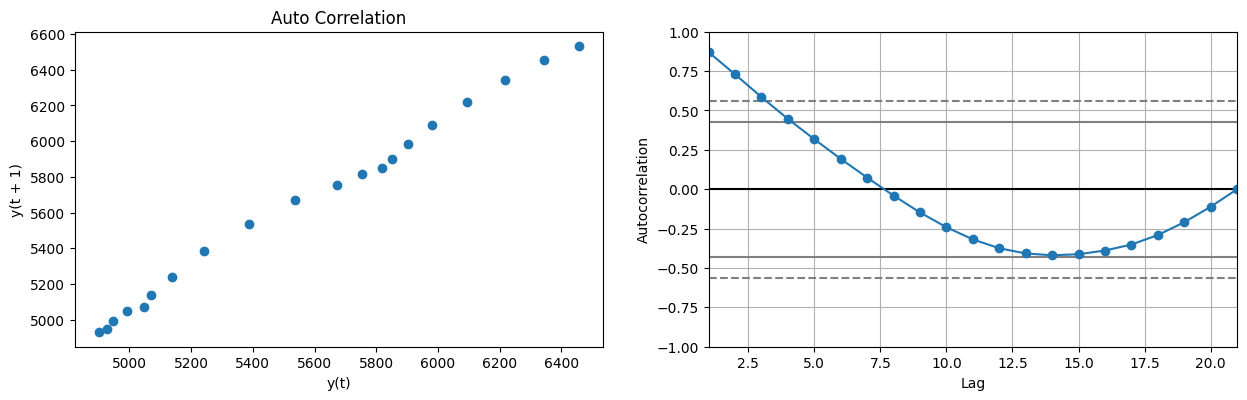

In [157]:
plt.figure(figsize=(15,9))
plt.subplot(221)
lag_plot(example_population)
plt.title('Auto Correlation')

plt.subplot(222)
autocorrelation_plot(example_population, marker='o')

plt.show()

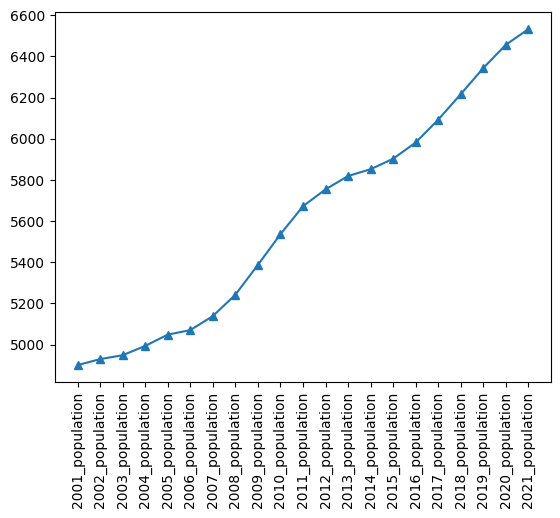

In [158]:
plt.plot(example_population, marker='^')
plt.xticks(rotation=90)
plt.show()

Test RMSE: 111.688


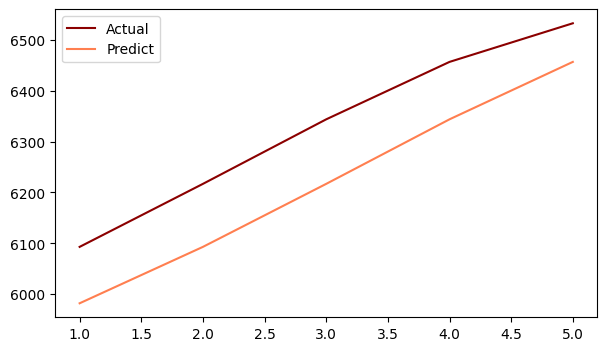

In [159]:
persistence_model_pipeline(example_population, 5)

predicted=6099.857937, expected=6093.000000
predicted=6223.776029, expected=6217.000000
predicted=6340.334745, expected=6344.000000
predicted=6448.677423, expected=6457.000000
predicted=6542.497068, expected=6533.000000
Test RMSE: 7.292


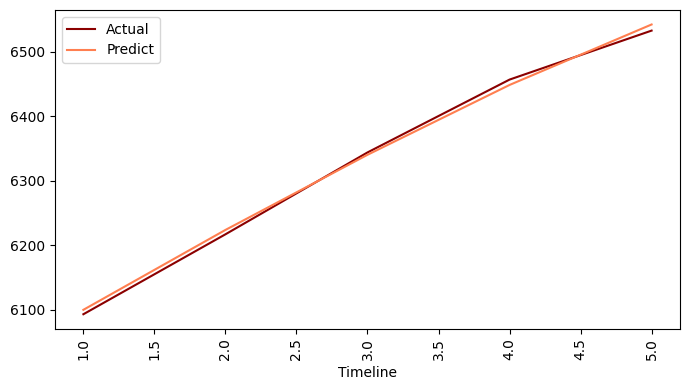

[6099.857937268114,
 6223.7760292911325,
 6340.334744929414,
 6448.677423122254,
 6542.4970680505885]

In [160]:
autoregression_model_pipeline(example_population, 5, 5, 5)

In [127]:
population_col = population_data.columns.to_list()
population_pred_col = ['2022_population',
                        '2023_population',
                        '2024_population',
                        '2025_population',
                        '2026_population',
                        '2027_population']
population_col.extend(population_pred_col)

In [145]:
# create and evaluate an updated autoregressive model
# split dataset
PREDICT_YEAR = 6
population_result_df = pd.DataFrame()
lag_value = 5

index = 0
while index < len(population_data):
	predictions = autoregression_model_pipeline(population_data.iloc[index,:], 0, PREDICT_YEAR, lag_value)

	total_value = population_data.iloc[index,:].to_list()
	total_value.extend(predictions)
	
	temp = pd.DataFrame()
	temp = temp.append(total_value).transpose()
	population_result_df = population_result_df.append(temp).reset_index(drop=True)
	index += 1

population_result_df.columns = population_col
population_result_df['SA2_Code'] = sa2['SA2_Code']
population_result_df['SA2_name'] = sa2['SA2_name']

population_result_df


,2001_population,2002_population,2003_population,2004_population,2005_population,2006_population,2007_population,2008_population,2009_population,2010_population,...,2020_population,2021_population,2022_population,2023_population,2024_population,2025_population,2026_population,2027_population,SA2_Code,SA2_name
0,5756.0,6092.0,6293.0,6480.0,6648.0,6761.0,7034.0,7272.0,7614.0,7894.0,...,15472.0,16823.0,18293.442531,10449.689320,12670.081190,16753.762513,14867.570969,16691.846376,201011001.0,Alfredton
1,11497.0,11708.0,12015.0,12189.0,12269.0,12356.0,12408.0,12480.0,12476.0,12462.0,...,12183.0,12076.0,12124.089402,12295.589359,12117.828989,12253.951820,12344.222914,12135.034431,201011002.0,Ballarat
2,5320.0,5399.0,5557.0,5620.0,5857.0,6037.0,6131.0,6252.0,6431.0,6595.0,...,7369.0,7232.0,6969.540548,7075.189526,7159.073828,7238.731094,7404.179322,7221.450360,201011005.0,Buninyong
3,4154.0,4225.0,4371.0,4465.0,4704.0,5041.0,5206.0,5349.0,5557.0,5699.0,...,9736.0,10640.0,11750.043245,6016.208099,8687.934139,7879.157795,9838.664100,10711.655405,201011006.0,Delacombe
4,3317.0,3378.0,3411.0,3473.0,3508.0,3542.0,3594.0,3658.0,3714.0,3774.0,...,4148.0,4213.0,4245.208800,3955.595136,3976.601136,4096.482017,4289.499715,4200.888890,201011007.0,Smythes Creek
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,3452.0,3479.0,3511.0,3511.0,3492.0,3459.0,3489.0,3501.0,3490.0,3460.0,...,3905.0,3978.0,4064.713484,3340.680848,3772.033015,3786.931148,3717.887406,4013.963901,217031476.0,Otway
518,6718.0,6704.0,6676.0,6643.0,6638.0,6652.0,6606.0,6631.0,6703.0,6739.0,...,6873.0,6989.0,7095.525912,6496.706799,6763.916302,6672.863098,6985.394690,6955.243564,217041477.0,Moyne - East
519,8317.0,8387.0,8450.0,8487.0,8517.0,8601.0,8694.0,8792.0,8878.0,8965.0,...,9842.0,9963.0,10044.279263,9683.988620,9863.664744,9746.049067,9909.894639,9929.459941,217041478.0,Moyne - West
520,17053.0,17449.0,17726.0,17937.0,18172.0,18528.0,18877.0,19107.0,19369.0,19634.0,...,22379.0,22462.0,22577.284970,21001.307977,22145.047699,21961.816088,22429.423506,22580.149777,217041479.0,Warrnambool - North


In [163]:
population_result_df.iloc[0,:27]

2001_population          5756.0
2002_population          6092.0
2003_population          6293.0
2004_population          6480.0
2005_population          6648.0
2006_population          6761.0
2007_population          7034.0
2008_population          7272.0
2009_population          7614.0
2010_population          7894.0
2011_population          8452.0
2012_population          9060.0
2013_population          9714.0
2014_population         10338.0
2015_population         11039.0
2016_population         11852.0
2017_population         12639.0
2018_population         13520.0
2019_population         14408.0
2020_population         15472.0
2021_population         16823.0
2022_population    18293.442531
2023_population     10449.68932
2024_population     12670.08119
2025_population    16753.762513
2026_population    14867.570969
2027_population    16691.846376
Name: 0, dtype: object

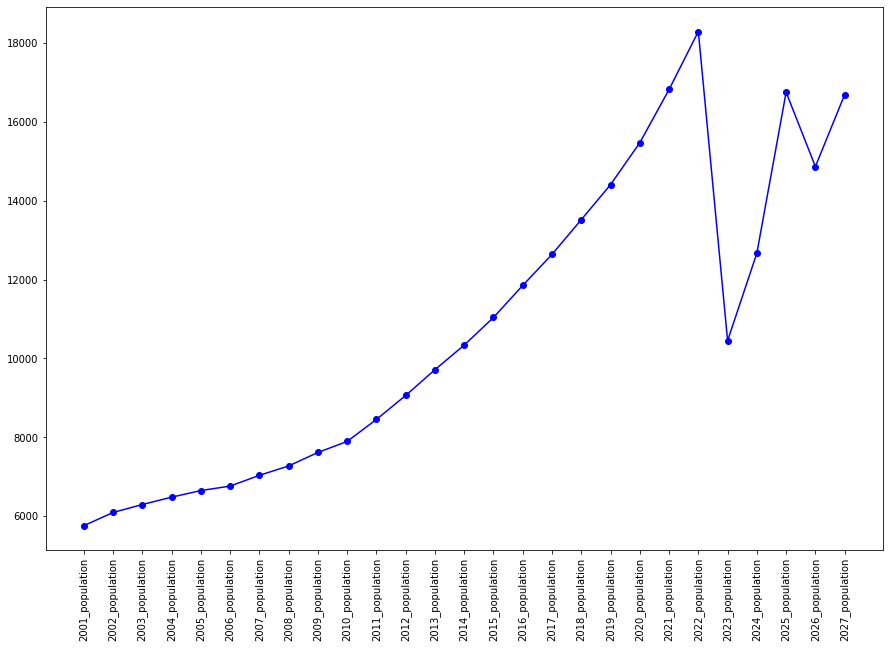

In [162]:
# plot
plt.figure(figsize=(15,10))
plt.plot(population_col, population_result_df.iloc[0,:27], color='b', marker='o')
plt.xticks(rotation=90)
plt.show()

In [164]:
population_result_df.to_csv('../data/curated/predict_population_AutoReg.csv', index=False)

#### linear ols

In [5]:
# for income prediction
# income_median_df = population_data[['2014-15_median_income', '2015-16_median_income',
#                                     '2016-17_median_income', '2017-18_median_income',
#                                     '2018-19_median_income']]
# income_mean_df = population_data[['2014-15_mean_income', '2015-16_mean_income',
#                                 '2016-17_mean_income', '2017-18_mean_income', 
#                                 '2018-19_mean_income']]
# sa2_code = population_data['SA2_Code'].to_list()

In [6]:
population_history = []
population_history.append('SA2_Code')
for i in population_data.columns:
    if '_population' in i:
        population_history.append(i)

population_hist_data = population_data[population_history]

population_hist_data = population_hist_data.set_index('SA2_Code')

In [7]:
population_hist_data

,2001_population,2002_population,2003_population,2004_population,2005_population,2006_population,2007_population,2008_population,2009_population,2010_population,...,2012_population,2013_population,2014_population,2015_population,2016_population,2017_population,2018_population,2019_population,2020_population,2021_population
SA2_Code,,,,,,,,,,,,,,,,,,,,,
206041122.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206041122.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206041119.0,3731.0,3859.0,4243.0,4460.0,4495.0,4555.0,4806.0,5055.0,5202.0,5272.0,...,5280.0,5333.0,5374.0,5411.0,5475.0,5495.0,5409.0,5413.0,5378.0,4962.0
206041127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,0.0,0.0
206041126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205031093.0,17647.0,17801.0,17956.0,18117.0,18250.0,18359.0,18602.0,18891.0,19168.0,19787.0,...,20801.0,21181.0,21611.0,22039.0,22577.0,23270.0,23966.0,24739.0,25631.0,26723.0
205031093.0,17647.0,17801.0,17956.0,18117.0,18250.0,18359.0,18602.0,18891.0,19168.0,19787.0,...,20801.0,21181.0,21611.0,22039.0,22577.0,23270.0,23966.0,24739.0,25631.0,26723.0
205031093.0,17647.0,17801.0,17956.0,18117.0,18250.0,18359.0,18602.0,18891.0,19168.0,19787.0,...,20801.0,21181.0,21611.0,22039.0,22577.0,23270.0,23966.0,24739.0,25631.0,26723.0


In [ ]:
year = []
for i in population_hist_data.columns:
    temp = i.split('_')
    year.append(int(temp[0][-2:]))

In [ ]:
# check 1st sa2code population
populationdata_in_each_sa2_code = pd.DataFrame()
populationdata_in_each_sa2_code['Population'] = population_hist_data.iloc[0].tolist()
populationdata_in_each_sa2_code['Year'] = year
populationdata_in_each_sa2_code

In [ ]:
# unique sa2 code population trend
sa1 = population_hist_data.iloc[0].tolist()
year = ['2001_population', '2002_population', '2003_population',
        '2004_population', '2005_population', '2006_population',
        '2007_population', '2008_population', '2009_population',
        '2010_population', '2011_population', '2012_population',
        '2013_population', '2014_population', '2015_population',
        '2016_population', '2017_population', '2018_population',
        '2019_population', '2020_population', '2021_population']

In [ ]:
# plot population in one sa2 code
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
plt.ylabel("Population")
plt.xlabel("Time line")
plt.title("Trends in population")
plt.plot(year,sa1, color = 'r')

In [ ]:
# check 1st sa2code population
x = populationdata_in_each_sa2_code['Year']
y = populationdata_in_each_sa2_code['Population']
linear_model = sm.formula.ols('Population ~ Year', data = populationdata_in_each_sa2_code).fit()
print(linear_model.params)

In [ ]:
predict_population = pd.DataFrame()
predict_year = [22,23,24,25,26,27]
predict_population['Year'] = predict_year
predict_population['Population'] = None
predict_population

In [ ]:
predicted_population = linear_model.predict(exog=predict_population['Year'], transform=True)
predicted_population

In [ ]:
train_predict_population = linear_model.predict(exog=x, transform=True)
# The mean squared error
print("Train mean squared error: %.2f" % mean_squared_error(y, train_predict_population))
rmse = np.sqrt(mean_squared_error(y, train_predict_population))
print("Train RMSE is: ", rmse)

In [ ]:
predict_population['Population'] = predicted_population

In [ ]:
dfs = [populationdata_in_each_sa2_code, predict_population]
five_years_population = pd.concat(dfs)

In [ ]:
five_years_population.reset_index().drop(columns='index')
five_years_population['Year'] = ['2001_population', '2002_population', '2003_population',
       '2004_population', '2005_population', '2006_population',
       '2007_population', '2008_population', '2009_population',
       '2010_population', '2011_population', '2012_population',
       '2013_population', '2014_population', '2015_population',
       '2016_population', '2017_population', '2018_population',
       '2019_population', '2020_population', '2021_population',
       '2022_population', '2023_population', '2024_population',
       '2025_population', '2026_population', '2027_population']

In [ ]:
five_years_population

In [ ]:
# plot predict population in one sa2 code
plt.figure(figsize=(20,7))
plt.xticks(rotation=45)
plt.ylabel("Population")
plt.xlabel("Time line")
plt.title("Trends in predict population")
plt.plot(five_years_population['Year'],five_years_population['Population'], color = 'r')

In [ ]:
All_sa2_code_predict_population = pd.DataFrame()
year = []
for i in population_hist_data.columns:
    temp = i.split('_')
    year.append(int(temp[0][-2:]))


predict_population_list = {}
for i in range(len(population_hist_data)):

    # create df ready to fit each row
    populationdata_in_each_sa2_code = pd.DataFrame()
    populationdata_in_each_sa2_code['Population'] = population_hist_data.iloc[i].tolist()
    populationdata_in_each_sa2_code['Year'] = year

    # create df ready to predict
    predict_population = pd.DataFrame()
    predict_year = [22,23,24,25,26,27]
    predict_population['Year'] = predict_year
    predict_population['Population'] = None
    
    # build linear model
    linear_model = sm.formula.ols('Population ~ Year', data = populationdata_in_each_sa2_code).fit()

    # predict population
    predicted_population = linear_model.predict(exog=predict_population['Year'], transform=True)
    # print(predicted_population)
    # put predicted population in df
    predict_population['Population'] = predicted_population

    # concat history population and predict population
    dfs = [populationdata_in_each_sa2_code, predict_population]
    five_years_population = pd.concat(dfs)
    five_years_population = five_years_population.reset_index().drop(columns='index')
    five_years_population['Year'] = ['2001_population', '2002_population', '2003_population',
                                    '2004_population', '2005_population', '2006_population',
                                    '2007_population', '2008_population', '2009_population',
                                    '2010_population', '2011_population', '2012_population',
                                    '2013_population', '2014_population', '2015_population',
                                    '2016_population', '2017_population', '2018_population',
                                    '2019_population', '2020_population', '2021_population',
                                    '2022_population', '2023_population', '2024_population',
                                    '2025_population', '2026_population', '2027_population']
                                    
    five_years_population['SA2_Code'] = population_hist_data.index[i]

    predict_population_list[i] = five_years_population
    # predict_population_list.append(five_years_population)

In [ ]:
predict_population_list[0].transpose()

In [ ]:
predict_population_df = pd.DataFrame()
predict_population_df = predict_population_list[0].transpose()
for i in range(1, len(predict_population_list)):
    # print(i)
    predict_population_df = predict_population_df.append(predict_population_list[i].transpose())
predict_population_df

In [ ]:
population_data['SA2_Code'].astype('str')

In [ ]:
year_list = predict_population_df.loc['Year'].iloc[0].tolist()

final_predict_population_df = pd.DataFrame()

final_predict_population_df = predict_population_df.loc['Population']
final_predict_population_df.index = population_data['SA2_Code'].astype('str')
final_predict_population_df.columns = year_list
final_predict_population_df

In [ ]:
final_predict_population_df.to_csv('../data/curated/predicted_population.csv')

### Predict income

##### ols

In [4]:
income = pd.read_csv('../data/curated/income.csv')

In [5]:
income_data = income.loc[:, '2014-15_median_income': '2018-19_median_income'].copy()
sa2 = income[['SA2_Code', 'SA2_name']].copy()

In [6]:
sa2

,SA2_Code,SA2_name
0,201011001,Alfredton
1,201011002,Ballarat
2,201011003,Ballarat - North
3,201011004,Ballarat - South
4,201011005,Buninyong
...,...,...
457,217031476,Otway
458,217041477,Moyne - East
459,217041478,Moyne - West
460,217041479,Warrnambool - North


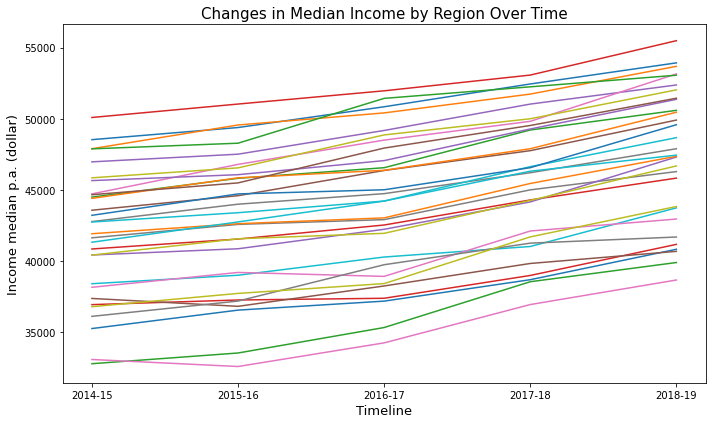

In [28]:
plt.figure(figsize=(10,6))

for i in range(30):
    plt.plot(income_data.columns.str.slice(stop=7).to_list(), income_data.iloc[i,:].copy())

plt.title('Changes in Median Income by Region Over Time', fontsize = 15)
plt.xlabel('Timeline', fontsize = 13)
plt.ylabel('Income median p.a. (dollar)', fontsize = 13)
plt.tight_layout()
plt.savefig('../plots/income_history.png')
plt.show()

In [7]:
income_timestep = income_data.columns.to_list()

d:\Python39\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     43.56
Date:                Sun, 09 Oct 2022   Prob (F-statistic):             0.0957
Time:                        17:34:45   Log-Likelihood:                -19.147
No. Observations:                   3   AIC:                             42.29
Df Residuals:                       1   BIC:                             40.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.224e+04   2632.278     12.248      0.0

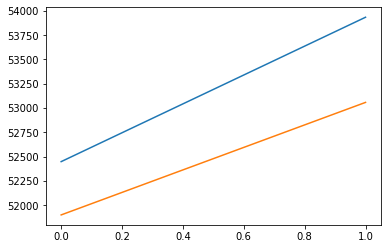

In [48]:
# use one instance as example to check r-square for the model
income_result_df = pd.DataFrame()
income_value = income_data.iloc[0, :].to_list()
income_train_year = [i for i in range(14, 17)]
income_predict_year = [i for i in range(17, 19)]
income_final_df = linear_model_function(income_train_year, income_value[:3], income_predict_year)
result = [income_result_df, income_final_df.transpose()]
income_result_df = pd.concat(result)

plt.plot(income_value[3:])
plt.plot(income_result_df.iloc[1,3:])
plt.show()

In [19]:
# train all historical income and predict future income for each region
income_result_df = pd.DataFrame()
for index in range(len(income_data)):
    income_value = income_data.iloc[index, :].to_list()
    income_train_year = [i for i in range(14, 19)]
    income_predict_year = [i for i in range(19, 28)]
    income_final_df = linear_model_function(income_train_year, income_value, income_predict_year)
    result = [income_result_df, income_final_df.transpose()]
    income_result_df = pd.concat(result)

In [9]:
for i in range(19, 28):
    income_timestep.append(f'20{i}-{i+1}_median_income')


In [20]:
income_result_df = income_result_df.loc['Y', :].copy()
income_result_df.columns = income_timestep
income_result_df = income_result_df.reset_index(drop=True)
income_result_df['SA2_Code'] = sa2['SA2_Code']
income_result_df['SA2_name'] = sa2['SA2_name']
income_result_df

,2014-15_median_income,2015-16_median_income,2016-17_median_income,2017-18_median_income,2018-19_median_income,2019-20_median_income,2020-21_median_income,2021-22_median_income,2022-23_median_income,2023-24_median_income,2024-25_median_income,2025-26_median_income,2026-27_median_income,2027-28_median_income,SA2_Code,SA2_name
0,48532.0,49385.0,50845.0,52448.0,53932.0,55187.3,56573.6,57959.9,59346.2,60732.5,62118.8,63505.1,64891.4,66277.7,201011001,Alfredton
1,47894.0,49564.0,50413.0,51736.0,53688.0,54787.0,56163.0,57539.0,58915.0,60291.0,61667.0,63043.0,64419.0,65795.0,201011002,Ballarat
2,44494.0,45816.0,46561.0,49211.0,50593.0,52012.9,53572.2,55131.5,56690.8,58250.1,59809.4,61368.7,62928.0,64487.3,201011003,Ballarat - North
3,40846.0,41544.0,42531.0,44293.0,45828.0,46822.3,48093.6,49364.9,50636.2,51907.5,53178.8,54450.1,55721.4,56992.7,201011004,Ballarat - South
4,46972.0,47511.0,49179.0,51034.0,52377.0,53714.5,55147.8,56581.1,58014.4,59447.7,60881.0,62314.3,63747.6,65180.9,201011005,Buninyong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,31322.0,33020.0,32563.0,33929.0,36219.0,36621.5,37691.8,38762.1,39832.4,40902.7,41973.0,43043.3,44113.6,45183.9,217031476,Otway
458,40775.0,40053.0,41244.0,44000.0,46071.0,46790.3,48244.2,49698.1,51152.0,52605.9,54059.8,55513.7,56967.6,58421.5,217041477,Moyne - East
459,39961.0,41751.0,42159.0,43136.0,45256.0,46045.1,47242.6,48440.1,49637.6,50835.1,52032.6,53230.1,54427.6,55625.1,217041478,Moyne - West
460,42635.0,43536.0,44772.0,46945.0,48855.0,50103.3,51688.2,53273.1,54858.0,56442.9,58027.8,59612.7,61197.6,62782.5,217041479,Warrnambool - North


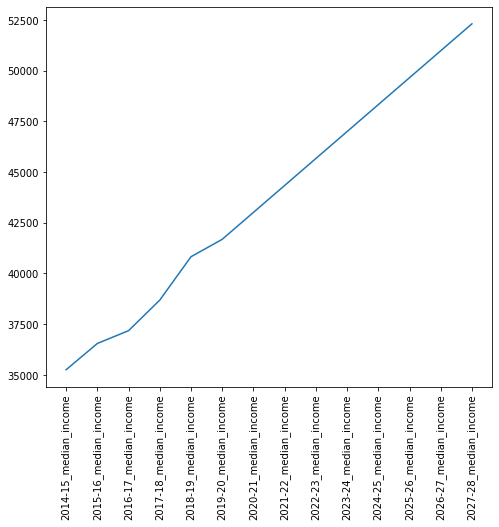

In [12]:
# plt.figure(figsize=(8,7))
# plt.plot(income_result_df.iloc[10, :14])
# plt.xticks(rotation=90)
# plt.show()

In [21]:
income_result_df.to_csv('../data/curated/predict_income_ols.csv', index=False)

### Predict affordable

### Predict house price

In [5]:
house_price_data = pd.read_csv('../data/curated/house_price.csv')

In [6]:
locality = house_price_data['locality']

In [7]:
house_price_data = house_price_data.replace('', 0)
house_price_data = house_price_data.replace('-', 0)
house_price_data =  house_price_data.replace(np.nan, 0)

In [16]:
house_price_data.loc[411]

locality              LINTON
2010 Median           152500
2011 Median           168500
2012 Median           187500
2013 Median           163500
2014 Median           208000
2015 Median           152000
2016 Median           202500
2017 Median           255000
2018 Median           236500
2019 Median           256500
2020 Median           337500
prelim 2021 Median       0.0
change 2019-2020        32.0
change 2010-2020       122.0
Growth PA                8.3
Name: 411, dtype: object

In [17]:
house_price_data.columns

Index(['locality', '2010 Median', '2011 Median', '2012 Median', '2013 Median',
       '2014 Median', '2015 Median', '2016 Median', '2017 Median',
       '2018 Median', '2019 Median', '2020 Median', 'prelim 2021 Median',
       'change 2019-2020', 'change 2010-2020', 'Growth PA'],
      dtype='object')

In [8]:
price_median = ['2010 Median', '2011 Median', '2012 Median', '2013 Median',
       '2014 Median', '2015 Median', '2016 Median', '2017 Median',
       '2018 Median', '2019 Median', '2020 Median']

train_median_price = house_price_data[price_median]
train_median_price

,2010 Median,2011 Median,2012 Median,2013 Median,2014 Median,2015 Median,2016 Median,2017 Median,2018 Median,2019 Median,2020 Median
0,736000,730000,714000,792500,862500,925000,1187500,1280000,1192500,1050000,1205000
1,1046500,994000,852500,947500,1045000,1207500,1300000,1471000,1500000,1390000,1620000
2,0,0,0,0,0,590000,607500,571000,568500,593000,685000
3,606000,680000,634000,664000,625500,680000,715000,737500,869000,985000,1125000
4,575000,557500,495000,532000,575000,635000,742000,845000,845000,795000,807500
...,...,...,...,...,...,...,...,...,...,...,...
781,166000,195500,215000,190000,202500,245000,230000,225000,218000,240000,260000
782,647000,607000,613000,696000,710000,810000,900500,1000000,1045000,974000,1038500
783,297000,270000,300000,302500,297000,300500,320000,324500,345000,375000,451000
784,240000,270000,255000,260000,255000,260000,305000,386500,392500,441000,422500


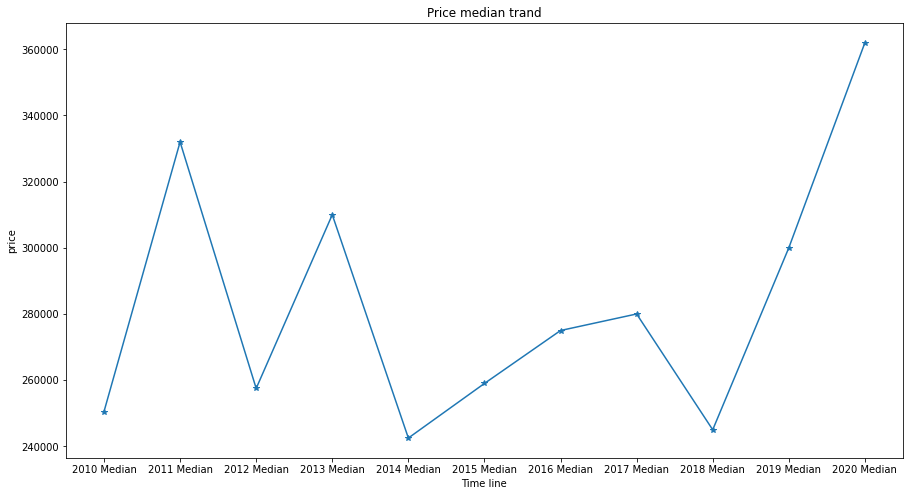

In [20]:
plt.figure(figsize=(15,8))
plt.plot(price_median, train_median_price.iloc[10,:].astype('int'), marker='*')
plt.title('Price median trand')
plt.ylabel('price')
plt.xlabel('Time line')
plt.show()

#### auto reg

In [13]:
example_house = train_median_price.iloc[10,:].astype('int').copy()

In [29]:
example_house

2010 Median    250500
2011 Median    332000
2012 Median    257500
2013 Median    310000
2014 Median    242500
2015 Median    259000
2016 Median    275000
2017 Median    280000
2018 Median    245000
2019 Median    300000
2020 Median    362000
Name: 10, dtype: int32

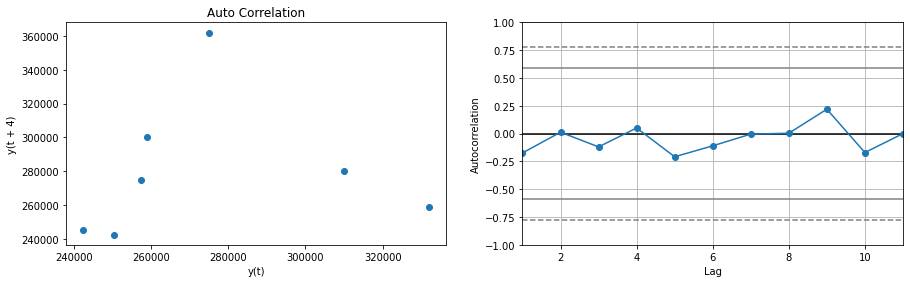

In [23]:
plt.figure(figsize=(15,9))
plt.subplot(221)
lag_plot(example_house)
plt.title('Auto Correlation')

plt.subplot(222)
autocorrelation_plot(example_house, marker='o')

plt.show()

Test MSE: 2029750000.000


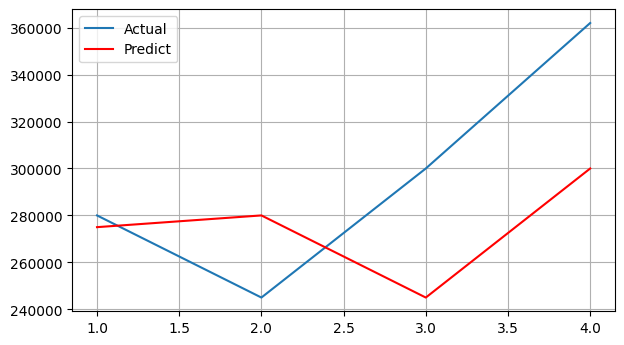

In [24]:
persistence_model_pipeline(example_house, 4)

predicted=270603.629161, expected=280000.000000
predicted=268869.370352, expected=245000.000000
predicted=281009.182012, expected=300000.000000
predicted=261932.335118, expected=362000.000000
Test RMSE: 52517.205


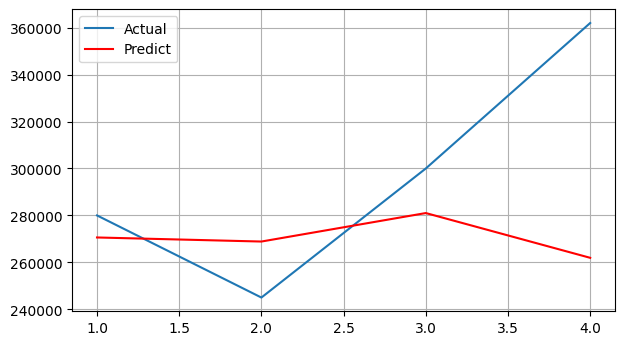

[270603.6291608615, 268869.3703523408, 281009.18201198534, 261932.3351182582]

In [33]:
autoregression_model_pipeline(example_house, 4, 4, 1)

In [30]:
house_col = train_median_price.columns.to_list()
house_pred_col = ['2021 Median',
                    '2022 Median',
                    '2023 Median',
                    '2024 Median',
                    '2025 Median',
                    '2026 Median',
                    '2027 Median']
house_col.extend(house_pred_col)

In [41]:
# create and evaluate an updated autoregressive model
# split dataset
HOUSE_PREDICT_YEAR = 7
house_result_df = pd.DataFrame()
lag_value = 2

index = 0
while index < len(train_median_price):
	predictions = autoregression_model_pipeline(train_median_price.iloc[index,:].astype('int'), 0, HOUSE_PREDICT_YEAR, lag_value)

	total_value = train_median_price.iloc[index,:].astype('int').copy().to_list()
	total_value.extend(predictions)
	
	temp = pd.DataFrame()
	temp = temp.append(total_value).transpose()
	house_result_df = house_result_df.append(temp).reset_index(drop=True)
	index += 1

house_result_df.columns = house_col
house_result_df['locality'] = locality

house_result_df


,2010 Median,2011 Median,2012 Median,2013 Median,2014 Median,2015 Median,2016 Median,2017 Median,2018 Median,2019 Median,2020 Median,2021 Median,2022 Median,2023 Median,2024 Median,2025 Median,2026 Median,2027 Median,locality
0,736000.0,730000.0,714000.0,792500.0,862500.0,925000.0,1187500.0,1280000.0,1192500.0,1050000.0,1205000.0,1.222100e+06,8.973499e+05,1.014737e+06,1.230096e+06,1.261499e+06,1.168747e+06,1.061748e+06,ABBOTSFORD
1,1046500.0,994000.0,852500.0,947500.0,1045000.0,1207500.0,1300000.0,1471000.0,1500000.0,1390000.0,1620000.0,1.642053e+06,1.246260e+06,1.288920e+06,1.379659e+06,1.519194e+06,1.563931e+06,1.486178e+06,ABERFELDIE
2,0.0,0.0,0.0,0.0,0.0,590000.0,607500.0,571000.0,568500.0,593000.0,685000.0,6.736043e+05,1.923498e+05,6.107599e+05,6.192421e+05,5.935175e+05,5.919982e+05,6.092059e+05,AINTREE
3,606000.0,680000.0,634000.0,664000.0,625500.0,680000.0,715000.0,737500.0,869000.0,985000.0,1125000.0,1.363725e+06,9.133138e+05,6.969225e+05,7.637485e+05,8.066886e+05,9.578150e+05,1.152355e+06,AIREYS INLET
4,575000.0,557500.0,495000.0,532000.0,575000.0,635000.0,742000.0,845000.0,845000.0,795000.0,807500.0,8.091665e+05,5.171307e+05,6.995388e+05,8.032393e+05,8.800725e+05,8.319836e+05,7.704353e+05,AIRPORT WEST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,166000.0,195500.0,215000.0,190000.0,202500.0,245000.0,230000.0,225000.0,218000.0,240000.0,260000.0,2.465650e+05,2.152626e+05,2.396722e+05,2.303953e+05,2.281722e+05,2.245830e+05,2.365401e+05,YARRAM
782,647000.0,607000.0,613000.0,696000.0,710000.0,810000.0,900500.0,1000000.0,1045000.0,974000.0,1038500.0,1.057269e+06,8.069101e+05,8.659203e+05,9.414520e+05,1.023412e+06,1.063742e+06,1.011361e+06,YARRAVILLE
783,297000.0,270000.0,300000.0,302500.0,297000.0,300500.0,320000.0,324500.0,345000.0,375000.0,451000.0,5.781909e+05,3.172533e+05,3.027089e+05,3.375142e+05,3.480597e+05,3.847603e+05,4.403395e+05,YARRAWONGA
784,240000.0,270000.0,255000.0,260000.0,255000.0,260000.0,305000.0,386500.0,392500.0,441000.0,422500.0,4.235888e+05,2.474044e+05,2.848355e+05,3.321630e+05,4.109970e+05,4.018326e+05,4.527240e+05,YEA


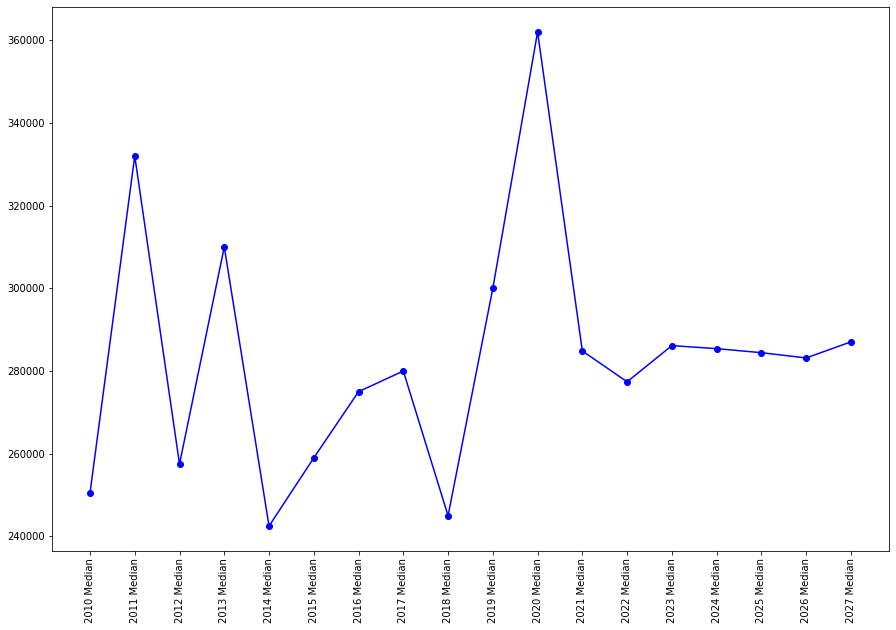

In [44]:
# plot
plt.figure(figsize=(15,10))
plt.plot(house_result_df.columns.to_list()[:18], house_result_df.iloc[10,:18].copy(), color='b', marker='o')
plt.xticks(rotation=90)
plt.show()

#### ols

In [ ]:
# predict_median_price = linear_model_function(x_train, y_train, x_predict)
predict_median_price = pd.DataFrame()
for index in range(len(train_median_price)):
    median_price_value = train_median_price.iloc[index, :].astype('float').copy().to_list()
    # print(median_price_value)
    median_price_train_year = [i for i in range(10, 21)]
    median_price_predict_year = [i for i in range(21, 28)]
    median_final_df = linear_model_function(median_price_train_year, median_price_value, median_price_predict_year)
    result = [predict_median_price, median_final_df.transpose()]
    predict_median_price = pd.concat(result)

In [ ]:
predict_median_price = predict_median_price.astype('int')

In [ ]:
median_price_timeline = []
# locality = house_price_data['locality']
for i in range(10, 28):
    median_price_timeline.append(f'20{i}_median')

In [ ]:
predict_median_price = predict_median_price.loc['Y', :].copy()
predict_median_price

In [ ]:
predict_median_price.columns = median_price_timeline
predict_median_price

In [ ]:
predict_median_price['locality'] = house_price_data['locality'].tolist()
predict_median_price

In [ ]:
predict_median_price = predict_median_price.set_index('locality')
predict_median_price

In [ ]:
predict_median_price.to_csv('../data/curated/predict_house_price_median.csv')

In [3]:
p = pd.read_csv('../data/curated/predict_house_price_median.csv')
p

,locality,2010_median,2011_median,2012_median,2013_median,2014_median,2015_median,2016_median,2017_median,2018_median,2019_median,2020_median,2021_median,2022_median,2023_median,2024_median,2025_median,2026_median,2027_median
0,ABBOTSFORD,736000,730000,714000,792500,862500,925000,1187500,1280000,1192500,1050000,1205000,1317390,1375213,1433036,1490859,1548681,1606504,1664327
1,ABERFELDIE,1046500,994000,852500,947500,1045000,1207500,1300000,1471000,1500000,1390000,1620000,1635599,1705563,1775527,1845490,1915454,1985418,2055381
2,AINTREE,0,0,0,0,0,590000,607500,571000,568500,593000,685000,833290,917400,1001509,1085618,1169727,1253836,1337945
3,AIREYS INLET,606000,680000,634000,664000,625500,680000,715000,737500,869000,985000,1125000,1015899,1059140,1102381,1145622,1188863,1232104,1275345
4,AIRPORT WEST,575000,557500,495000,532000,575000,635000,742000,845000,845000,795000,807500,888845,924804,960763,996722,1032681,1068640,1104599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,YARRAM,166000,195500,215000,190000,202500,245000,230000,225000,218000,240000,260000,258154,265013,271872,278731,285590,292449,299309
782,YARRAVILLE,647000,607000,613000,696000,710000,810000,900500,1000000,1045000,974000,1038500,1122999,1173181,1223363,1273545,1323727,1373909,1424090
783,YARRAWONGA,297000,270000,300000,302500,297000,300500,320000,324500,345000,375000,451000,401609,414263,426918,439572,452227,464881,477536
784,YEA,240000,270000,255000,260000,255000,260000,305000,386500,392500,441000,422500,443154,464172,485190,506209,527227,548245,569263


In [7]:
p.iloc[0,1:].to_list()

[736000,
 730000,
 714000,
 792500,
 862500,
 925000,
 1187500,
 1280000,
 1192500,
 1050000,
 1205000,
 1317390,
 1375213,
 1433036,
 1490859,
 1548681,
 1606504,
 1664327]

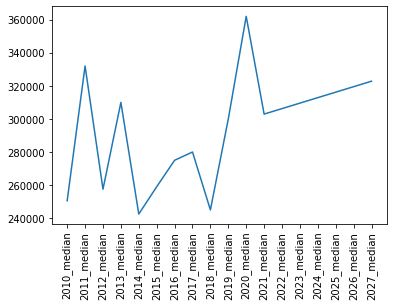

In [9]:
plt.plot(p.columns[1:].to_list(), p.iloc[10,1:].to_list())
plt.xticks(rotation=90)
plt.show()

### Predict rental median

In [46]:
rental_median_data = pd.read_csv('../data/curated/rental_median.csv')

In [47]:
rental_median_data['Rental_total_Jun_2000']

0      180
1      145
2      225
3      240
4      150
      ... 
208    170
209    146
210    135
211    260
212    230
Name: Rental_total_Jun_2000, Length: 213, dtype: int64

In [48]:
column_names = []
for i in rental_median_data.columns:
    if 'total' in i and 'b' not in i:
        column_names.append(i)

# column_names

In [49]:
rental_data = rental_median_data[column_names]
rental_data = rental_data.replace('-', 0)
rental_data

,Rental_total_Mar_2000,Rental_total_Jun_2000,Rental_total_Sep_2000,Rental_total_Dec_2000,Rental_total_Mar_2001,Rental_total_Jun_2001,Rental_total_Sep_2001,Rental_total_Dec_2001,Rental_total_Mar_2002,Rental_total_Jun_2002,...,Rental_total_Mar_2019,Rental_total_Jun_2019,Rental_total_Sep_2019,Rental_total_Dec_2019,Rental_total_Mar_2020,Rental_total_Jun_2020,Rental_total_Sep_2020,Rental_total_Dec_2020,Rental_total_Mar_2021,Rental_total_Jun_2021
0,175,180,180,180,180,185,190,195,200,200,...,480,480,490,490,495,495,490,485,480,480
1,145,145,150,150,150,150,150,150,150,155,...,310,320,320,325,330,330,330,330,340,350
2,220,225,230,240,245,240,245,250,250,260,...,435,440,450,450,450,450,450,430,425,420
3,240,240,240,240,250,255,260,263,263,260,...,520,515,510,530,530,530,520,518,500,500
4,150,150,155,170,163,170,165,170,175,180,...,380,380,380,390,390,390,390,390,390,390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,165,170,170,170,175,175,175,180,180,180,...,400,400,400,400,400,400,400,400,400,400
209,150,146,150,155,160,165,165,170,175,180,...,420,445,450,460,460,440,420,420,410,400
210,130,135,135,135,140,140,140,150,150,155,...,320,320,330,330,340,340,340,350,350,360
211,260,260,270,275,275,280,280,290,300,300,...,550,560,565,595,600,585,560,550,500,500


In [ ]:
c1, c2, c3, c4, c5 = sns.color_palette("husl", 5)
ax1 = plt.subplot2grid((3,2), (0,0))
ax2 = plt.subplot2grid((3,2), (0,1))
ax3 = plt.subplot2grid((3,2), (1,0))
ax4 = plt.subplot2grid((3,2), (1,1))
ax5 = plt.subplot2grid((3,2), (2,0))
d1.lag_plot(ax=ax1, color = c1, alpha=0.5)
d2.lag_plot(ax=ax2, color = c2, alpha=0.5)
d3.lag_plot(ax=ax3, color = c3, alpha=0.5)
d4.lag_plot(ax=ax4, color = c4, alpha=0.5)

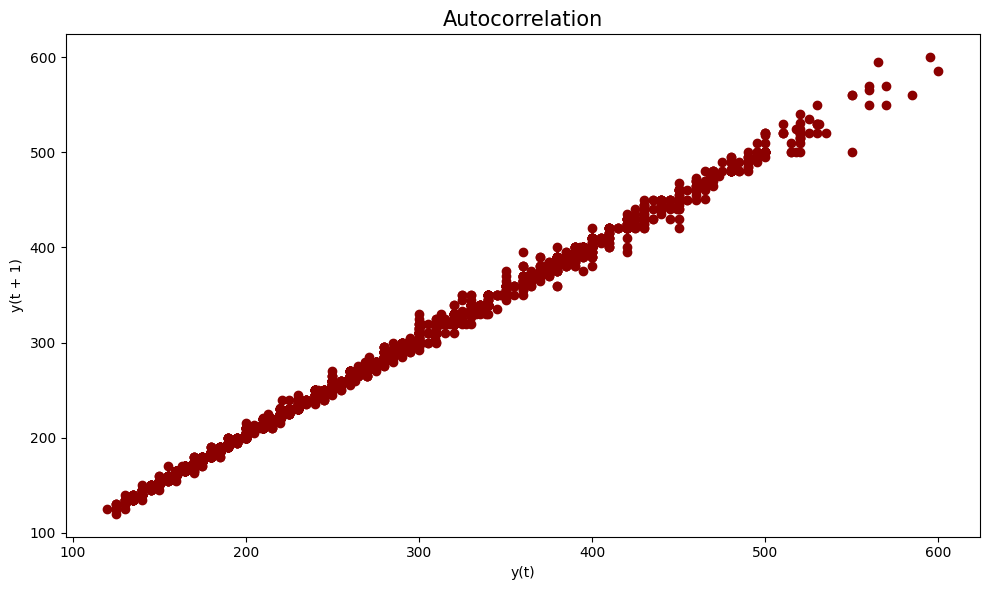

In [132]:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (10,6))
for i in range(30):
    lag_plot(rental_data.loc[i].astype('int'), c='darkred', ax =ax)
plt.title('Autocorrelation', fontsize=15)
plt.tight_layout()
plt.savefig('../plots/t_t+1_corr.png')
plt.show()


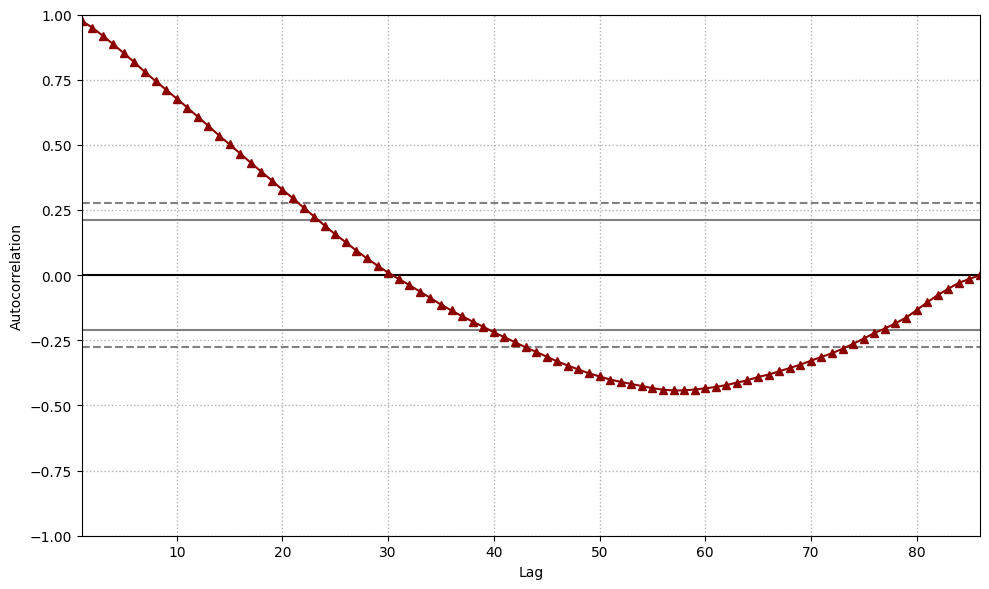

In [145]:
from pandas.plotting import autocorrelation_plot
fig, ax = plt.subplots(figsize = (10,6))
autocorrelation_plot(rental_data.loc[5].astype('int'), c='darkred', marker='^')
ax.grid(linestyle=':', linewidth=1)
plt.tight_layout()
plt.savefig('../plots/autocorrelation.png')
plt.show()


<Figure size 648x504 with 0 Axes>

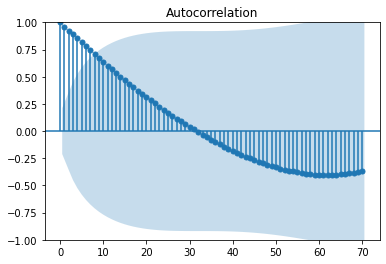

In [171]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(9,7))
plot_acf(rental_data.loc[1].astype('int'), lags=70)
plt.show()

In [172]:
a = rental_data.loc[0].astype('int')
a

Rental_total_Mar_2000    175
Rental_total_Jun_2000    180
Rental_total_Sep_2000    180
Rental_total_Dec_2000    180
Rental_total_Mar_2001    180
                        ... 
Rental_total_Jun_2020    495
Rental_total_Sep_2020    490
Rental_total_Dec_2020    485
Rental_total_Mar_2021    480
Rental_total_Jun_2021    480
Name: 0, Length: 86, dtype: int32

In [173]:
df.dtypes

suburb                    object
Rental_total_Mar_2000    float64
Rental_total_Jun_2000    float64
Rental_total_Sep_2000    float64
Rental_total_Dec_2000    float64
                          ...   
Rental_total_Jun_2020    float64
Rental_total_Sep_2020    float64
Rental_total_Dec_2020    float64
Rental_total_Mar_2021    float64
Rental_total_Jun_2021    float64
Length: 87, dtype: object

Test MSE: 14.286


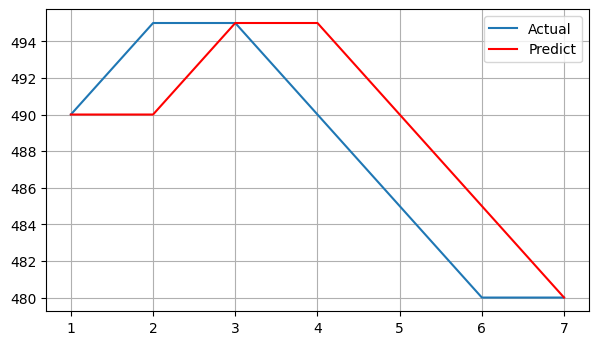

In [174]:
persistence_model_pipeline(rental_data.loc[0].astype('float'), 7)

In [108]:
rental_data.columns[-20:]

Index(['Rental_total_Sep_2016', 'Rental_total_Dec_2016',
       'Rental_total_Mar_2017', 'Rental_total_Jun_2017',
       'Rental_total_Sep_2017', 'Rental_total_Dec_2017',
       'Rental_total_Mar_2018', 'Rental_total_Jun_2018',
       'Rental_total_Sep_2018', 'Rental_total_Dec_2018',
       'Rental_total_Mar_2019', 'Rental_total_Jun_2019',
       'Rental_total_Sep_2019', 'Rental_total_Dec_2019',
       'Rental_total_Mar_2020', 'Rental_total_Jun_2020',
       'Rental_total_Sep_2020', 'Rental_total_Dec_2020',
       'Rental_total_Mar_2021', 'Rental_total_Jun_2021'],
      dtype='object')

predicted=504.470526, expected=520.000000
predicted=518.490657, expected=520.000000
predicted=509.813542, expected=520.000000
predicted=523.013516, expected=531.000000
predicted=535.534171, expected=530.000000
predicted=526.831376, expected=530.000000
predicted=544.668779, expected=550.000000
predicted=547.698296, expected=560.000000
predicted=550.590331, expected=570.000000
predicted=570.162774, expected=570.000000
predicted=557.243618, expected=550.000000
predicted=559.473550, expected=560.000000
predicted=550.834246, expected=565.000000
predicted=569.693596, expected=595.000000
predicted=584.985742, expected=600.000000
predicted=590.406520, expected=585.000000
predicted=583.820727, expected=560.000000
predicted=558.669491, expected=550.000000
predicted=554.323660, expected=500.000000
predicted=523.706149, expected=500.000000
Test RMSE: 17.766


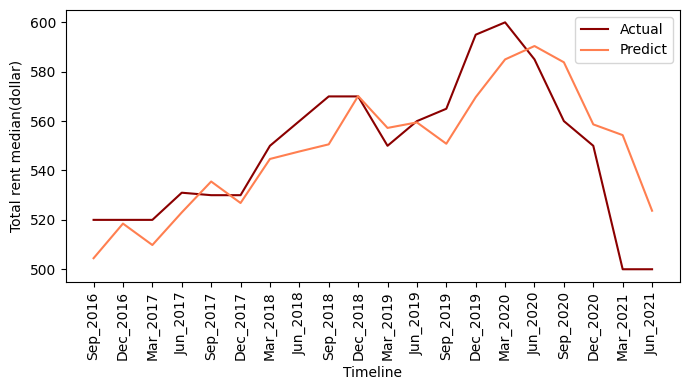

[504.4705264503827,
 518.4906565289673,
 509.8135418488643,
 523.0135161738888,
 535.5341714444722,
 526.8313760392576,
 544.6687787874321,
 547.698295703688,
 550.5903311381073,
 570.162773735977,
 557.2436177590664,
 559.4735504521493,
 550.834246386862,
 569.6935962527718,
 584.985741808922,
 590.4065200917962,
 583.820727336326,
 558.6694911839045,
 554.3236602599159,
 523.7061489346246]

In [147]:
autoregression_model_pipeline(rental_data.loc[5].astype('float'), 20, 20, 23)

In [176]:
rental_pred_name = ['Sep_2021',
					'Dec_2021',
					'Mar_2022',
					'Jun_2022',
					'Sep_2022',
					'Dec_2022',
					'Mar_2023',
					'Jun_2023',
					'Sep_2023',
					'Dec_2023',
					'Mar_2024',
					'Jun_2024',
					'Sep_2024',
					'Dec_2024',
					'Mar_2025',
					'Jun_2025',
					'Sep_2025',
					'Dec_2025',
					'Mar_2026',
					'Jun_2026',
					'Sep_2026',
					'Dec_2026',
					'Mar_2027',
					'Jun_2027',
					'Sep_2027',
					'Dec_2027']
rental_col = rental_data.columns.str.slice(start=13).to_list()
rental_col.extend(rental_pred_name)

In [177]:
# create and evaluate an updated autoregressive model
# split dataset
PREDICT_LEN = 26
result_df = pd.DataFrame()
lag_value = 23

index = 0
while index < len(rental_data):
	predictions = autoregression_model_pipeline(rental_data.iloc[index,:].astype('float'), 0, PREDICT_LEN, lag_value)
	

	total_value = rental_data.astype('float').iloc[index,:].to_list()
	total_value.extend(predictions)
	
	temp = pd.DataFrame()
	temp = temp.append(total_value).transpose()
	result_df = result_df.append(temp).reset_index(drop=True)
	index += 1

result_df.columns = rental_col
result_df['suburb'] = rental_median_data['suburb']

result_df


,Mar_2000,Jun_2000,Sep_2000,Dec_2000,Mar_2001,Jun_2001,Sep_2001,Dec_2001,Mar_2002,Jun_2002,...,Dec_2025,Mar_2026,Jun_2026,Sep_2026,Dec_2026,Mar_2027,Jun_2027,Sep_2027,Dec_2027,suburb
0,175.0,180.0,180.0,180.0,180.0,185.0,190.0,195.0,200.0,200.0,...,472.206287,516.491418,474.643085,485.864002,503.440168,483.912978,488.385414,483.911503,484.547703,YARRAVILLE
1,145.0,145.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,155.0,...,328.045832,324.923760,334.097642,335.553168,336.187029,353.675407,331.858821,335.758787,345.086805,WODONGA
2,220.0,225.0,230.0,240.0,245.0,240.0,245.0,250.0,250.0,260.0,...,438.240129,445.039466,455.011112,461.676035,455.996250,450.615165,445.272220,429.647564,424.114145,WINDSOR
3,240.0,240.0,240.0,240.0,250.0,255.0,260.0,263.0,263.0,260.0,...,521.912354,513.685696,519.226838,530.134806,538.373845,530.141439,518.984886,510.934268,501.058677,WILLIAMSTOWN
4,150.0,150.0,155.0,170.0,163.0,170.0,165.0,170.0,175.0,180.0,...,389.291592,385.097303,378.192172,392.668803,401.616743,386.659778,392.091374,390.410736,389.379426,WHITTLESEA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,165.0,170.0,170.0,170.0,175.0,175.0,175.0,180.0,180.0,180.0,...,389.224616,405.742677,401.707094,410.379378,392.548879,400.250469,399.943881,398.669316,402.603799,ALTONA
209,150.0,146.0,150.0,155.0,160.0,165.0,165.0,170.0,175.0,180.0,...,446.551272,463.081245,452.227812,458.693335,444.162921,423.936817,418.731264,412.183752,404.822325,ALPHINGTON
210,130.0,135.0,135.0,135.0,140.0,140.0,140.0,150.0,150.0,155.0,...,336.300762,337.586171,330.403965,353.111456,334.664872,342.352293,344.650800,351.063770,358.018183,ALFREDTON
211,260.0,260.0,270.0,275.0,275.0,280.0,280.0,290.0,300.0,300.0,...,549.904660,546.836880,570.225829,592.002128,594.825665,565.493326,550.246053,532.124745,506.714078,ALBERT PARK


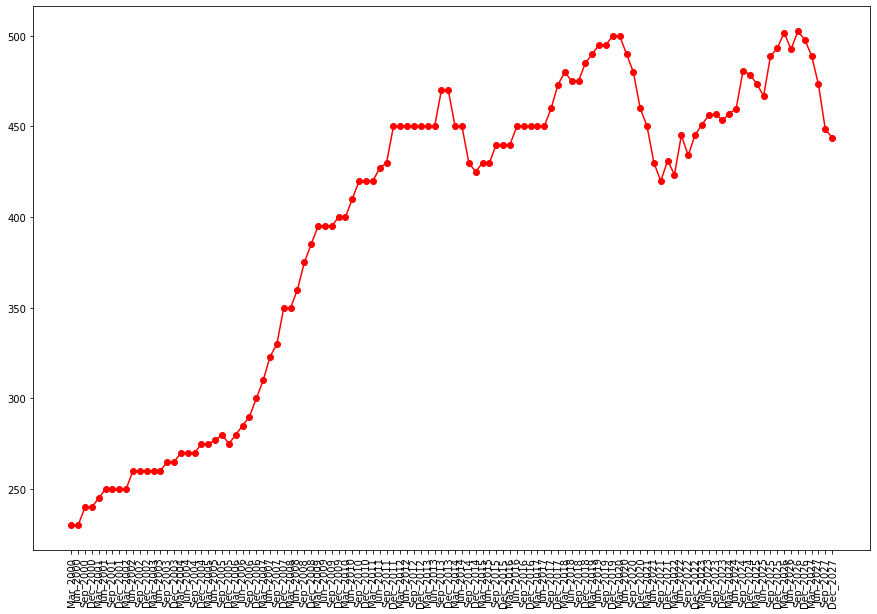

In [178]:
# plot
plt.figure(figsize=(15,10))
plt.plot(rental_col, total_value, color='red', marker='o')
plt.xticks(rotation=90)
plt.show()

In [179]:
result_df.to_csv('../data/curated/predict_rental_AutoReg.csv', index=False)

##### ols

In [11]:
month_list = ['Mar', 'Jun', 'Sep', 'Dec']
col_name_rental = []
for i in range(2021, 2028):
    count = 0
    if i == 2021:
        count = 2
        index = 2
        for j in range(count):
            col_name_rental.append(f'Rental_total_{month_list[index]}_{i}')
            index = index + 1
    else:
        count = 4
        index = 0
        for k in range(count):
            col_name_rental.append(f'Rental_total_{month_list[index]}_{i}')
            index = index + 1

col_name_rental

['Rental_total_Sep_2021',
 'Rental_total_Dec_2021',
 'Rental_total_Mar_2022',
 'Rental_total_Jun_2022',
 'Rental_total_Sep_2022',
 'Rental_total_Dec_2022',
 'Rental_total_Mar_2023',
 'Rental_total_Jun_2023',
 'Rental_total_Sep_2023',
 'Rental_total_Dec_2023',
 'Rental_total_Mar_2024',
 'Rental_total_Jun_2024',
 'Rental_total_Sep_2024',
 'Rental_total_Dec_2024',
 'Rental_total_Mar_2025',
 'Rental_total_Jun_2025',
 'Rental_total_Sep_2025',
 'Rental_total_Dec_2025',
 'Rental_total_Mar_2026',
 'Rental_total_Jun_2026',
 'Rental_total_Sep_2026',
 'Rental_total_Dec_2026',
 'Rental_total_Mar_2027',
 'Rental_total_Jun_2027',
 'Rental_total_Sep_2027',
 'Rental_total_Dec_2027']

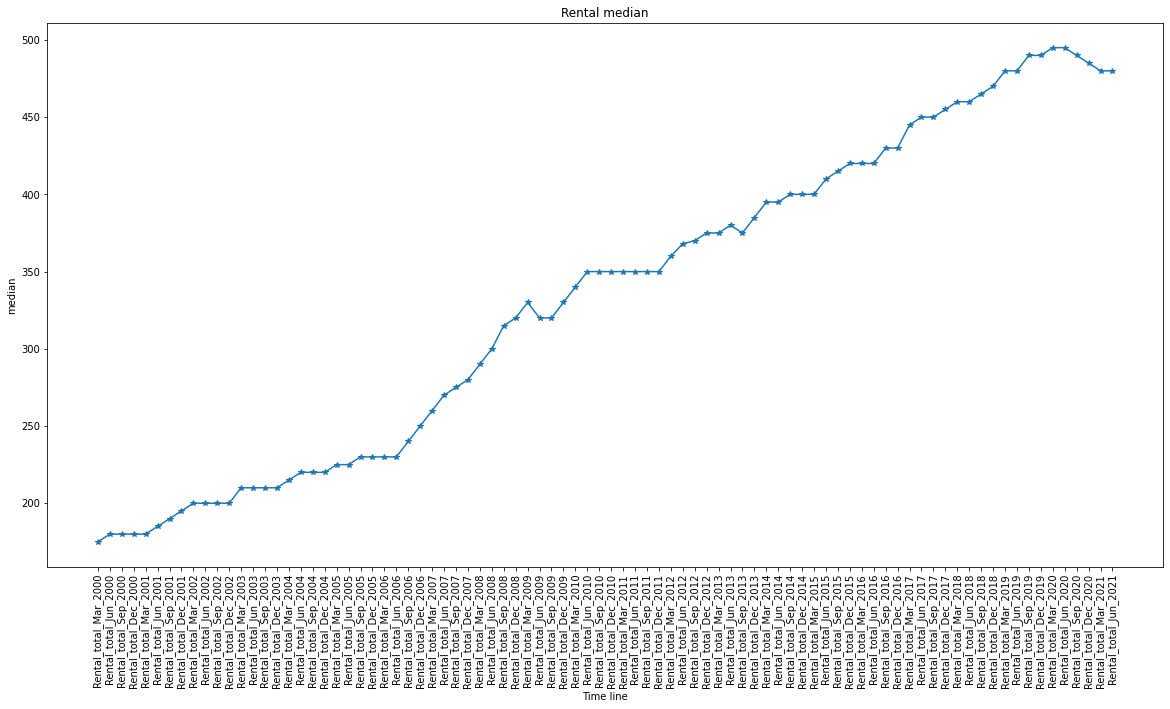

In [6]:
plt.figure(figsize=(20,10))
plt.plot(column_names, rental_data.loc[0].astype('int'), marker='*')
plt.title('Rental median')
plt.ylabel('median')
plt.xlabel('Time line')
plt.xticks(rotation=90)
plt.show()

In [63]:
# train_year = []
# for i in rental_data.columns:
#     train_year.append(int(i[-2:]))
# train_year


train_year = []
for year in range(22):
    for month in range(3,15,3):
        if month == 9 and year == 21:
                break
        months = year * 12 + month
        train_year.append(months)
            # print(year,'-',month)
len(train_year)

86

In [64]:

# predict_year
month_number = 4
predict_year_number = 6
lefted_year = 2


predict_end_year = lefted_year + month_number * predict_year_number
predict_year = []
continure_year = train_year[-1]
for i in range(predict_end_year):
    continure_year = continure_year + 3
    predict_year.append(continure_year)
predict_year

[261,
 264,
 267,
 270,
 273,
 276,
 279,
 282,
 285,
 288,
 291,
 294,
 297,
 300,
 303,
 306,
 309,
 312,
 315,
 318,
 321,
 324,
 327,
 330,
 333,
 336]

In [39]:
# predict_median_price = linear_model_function(x_train, y_train, x_predict)
predict_rental_median = pd.DataFrame()
for index in range(len(rental_data)):
    rental_median_value = rental_data.iloc[index, :].astype('float').to_list()
    # print(rental_median_value)
    rental_median_train_year = train_year
    rental_median_predict_year = predict_year
    rental_median_final_df = linear_model_function(rental_median_train_year, rental_median_value, rental_median_predict_year)
    final_df = [predict_rental_median, rental_median_final_df.transpose()]
    predict_rental_median = pd.concat(final_df)

Intercept    189.236662
X              1.212479
dtype: float64
Intercept    234.668947
X              1.488860
dtype: float64
Intercept    235.869767
X              1.485004
dtype: float64
Intercept    260.743639
X              1.081711
dtype: float64
Intercept    170.765800
X              1.075393
dtype: float64
Intercept    198.756224
X              1.072972
dtype: float64
Intercept    238.090834
X              1.431630
dtype: float64
Intercept    309.270041
X              1.262031
dtype: float64
Intercept    293.799453
X              1.050811
dtype: float64
Intercept    221.824897
X              1.065050
dtype: float64
Intercept    344.359234
X              0.872236
dtype: float64
Intercept    202.557866
X              0.969618
dtype: float64
Intercept    216.837756
X              1.267393
dtype: float64
Intercept    226.075513
X              1.357347
dtype: float64
Intercept    189.469494
X              1.087822
dtype: float64
Intercept    175.056635
X              1.104618
dtype: 

In [40]:
predict_rental_median = predict_rental_median.astype('int')
predict_rental_median

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
X,3,6,9,12,15,18,21,24,27,30,...,309,312,315,318,321,324,327,330,333,336
Y,200,200,205,210,215,220,225,230,235,230,...,563,567,571,574,578,582,585,589,592,596
X,3,6,9,12,15,18,21,24,27,30,...,309,312,315,318,321,324,327,330,333,336
Y,260,260,265,270,270,275,280,280,290,290,...,694,699,703,708,712,717,721,725,730,734
X,3,6,9,12,15,18,21,24,27,30,...,309,312,315,318,321,324,327,330,333,336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y,170,175,180,180,180,185,190,190,200,200,...,599,603,608,612,616,621,625,629,634,638
X,3,6,9,12,15,18,21,24,27,30,...,309,312,315,318,321,324,327,330,333,336
Y,150,155,155,160,160,160,160,160,165,165,...,425,428,431,433,436,439,442,445,448,451
X,3,6,9,12,15,18,21,24,27,30,...,309,312,315,318,321,324,327,330,333,336


In [41]:
predict_rental_median = predict_rental_median.loc['Y', :].copy()
predict_rental_median.shape

(141, 112)

In [42]:
month_list = ['Mar', 'Jun', 'Sep', 'Dec']
col_name_rental = []
for i in range(2021, 2028):
    count = 0
    if i == 2021:
        count = 2
        index = 2
        for j in range(count):
            col_name_rental.append(f'Rental_total_{month_list[index]}_{i}')
            index = index + 1
    else:
        count = 4
        index = 0
        for k in range(count):
            col_name_rental.append(f'Rental_total_{month_list[index]}_{i}')
            index = index + 1

col_name_rental

['Rental_total_Sep_2021',
 'Rental_total_Dec_2021',
 'Rental_total_Mar_2022',
 'Rental_total_Jun_2022',
 'Rental_total_Sep_2022',
 'Rental_total_Dec_2022',
 'Rental_total_Mar_2023',
 'Rental_total_Jun_2023',
 'Rental_total_Sep_2023',
 'Rental_total_Dec_2023',
 'Rental_total_Mar_2024',
 'Rental_total_Jun_2024',
 'Rental_total_Sep_2024',
 'Rental_total_Dec_2024',
 'Rental_total_Mar_2025',
 'Rental_total_Jun_2025',
 'Rental_total_Sep_2025',
 'Rental_total_Dec_2025',
 'Rental_total_Mar_2026',
 'Rental_total_Jun_2026',
 'Rental_total_Sep_2026',
 'Rental_total_Dec_2026',
 'Rental_total_Mar_2027',
 'Rental_total_Jun_2027',
 'Rental_total_Sep_2027',
 'Rental_total_Dec_2027']

In [43]:
train_col_name = column_names
for i in range(len(col_name_rental)):
    train_col_name.append(col_name_rental[i])

full_name = train_col_name
len(full_name)

112

In [44]:
predict_rental_median.columns = full_name
predict_rental_median

,Rental_total_Mar_2000,Rental_total_Jun_2000,Rental_total_Sep_2000,Rental_total_Dec_2000,Rental_total_Mar_2001,Rental_total_Jun_2001,Rental_total_Sep_2001,Rental_total_Dec_2001,Rental_total_Mar_2002,Rental_total_Jun_2002,...,Rental_total_Sep_2025,Rental_total_Dec_2025,Rental_total_Mar_2026,Rental_total_Jun_2026,Rental_total_Sep_2026,Rental_total_Dec_2026,Rental_total_Mar_2027,Rental_total_Jun_2027,Rental_total_Sep_2027,Rental_total_Dec_2027
Y,200,200,205,210,215,220,225,230,235,230,...,563,567,571,574,578,582,585,589,592,596
Y,260,260,265,270,270,275,280,280,290,290,...,694,699,703,708,712,717,721,725,730,734
Y,0,340,0,0,0,0,0,0,320,340,...,694,699,703,708,712,717,721,725,730,734
Y,265,268,280,273,290,295,300,320,320,320,...,594,598,601,604,607,611,614,617,620,624
Y,180,180,180,185,185,190,195,195,200,200,...,503,506,509,512,515,519,522,525,528,532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y,185,185,190,200,200,200,210,210,215,220,...,498,501,504,507,510,514,517,520,523,526
Y,170,175,180,180,180,185,190,190,200,200,...,599,603,608,612,616,621,625,629,634,638
Y,170,175,180,180,180,185,190,190,200,200,...,599,603,608,612,616,621,625,629,634,638
Y,150,155,155,160,160,160,160,160,165,165,...,425,428,431,433,436,439,442,445,448,451


In [45]:
predict_rental_median['surburb'] = rental_median_data['suburb'].tolist()
predict_rental_median = predict_rental_median.set_index('surburb')
predict_rental_median

,Rental_total_Mar_2000,Rental_total_Jun_2000,Rental_total_Sep_2000,Rental_total_Dec_2000,Rental_total_Mar_2001,Rental_total_Jun_2001,Rental_total_Sep_2001,Rental_total_Dec_2001,Rental_total_Mar_2002,Rental_total_Jun_2002,...,Rental_total_Sep_2025,Rental_total_Dec_2025,Rental_total_Mar_2026,Rental_total_Jun_2026,Rental_total_Sep_2026,Rental_total_Dec_2026,Rental_total_Mar_2027,Rental_total_Jun_2027,Rental_total_Sep_2027,Rental_total_Dec_2027
surburb,,,,,,,,,,,,,,,,,,,,,
ARMADALE,200,200,205,210,215,220,225,230,235,230,...,563,567,571,574,578,582,585,589,592,596
CARLTON NORTH,260,260,265,270,270,275,280,280,290,290,...,694,699,703,708,712,717,721,725,730,734
DOCKLANDS,0,340,0,0,0,0,0,0,320,340,...,694,699,703,708,712,717,721,725,730,734
EAST MELBOURNE,265,268,280,273,290,295,300,320,320,320,...,594,598,601,604,607,611,614,617,620,624
ST KILDA EAST,180,180,180,185,185,190,195,195,200,200,...,503,506,509,512,515,519,522,525,528,532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVONDALE HEIGHTS,185,185,190,200,200,200,210,210,215,220,...,498,501,504,507,510,514,517,520,523,526
NEWPORT,170,175,180,180,180,185,190,190,200,200,...,599,603,608,612,616,621,625,629,634,638
SPOTSWOOD,170,175,180,180,180,185,190,190,200,200,...,599,603,608,612,616,621,625,629,634,638


In [46]:
predict_rental_median.to_csv('../data/curated/predict_rental_median.csv')